# On the electromagnetic-electron rings originating from the interaction of high-power short-pulse laser and underdense plasma

P. Valenta$^{1, \ 2, \ *}$, G. M. Grittani$^{1}$, C. M. Lazzarini$^{1, \ 2}$, O. Klimo$^{1, \ 2}$, and S. V. Bulanov$^{1, \ 3}$

$^{1)}$ ELI Beamlines, Institute of Physics, Czech Academy of Sciences, Na Slovance 2, 18221 Prague, Czech Republic  
$^{2)}$ Faculty of Nuclear Sciences and Physical Engineering, Czech Technical University in Prague, Brehova 7, 11519 Prague, Czech Republic  
$^{3)}$ Kansai Photon Science Institute, National Institutes for Quantum and Radiological Science and Technology, Umemidai 8-1-7, Kizugawa, 619-0215 Kyoto, Japan  

$^{*}$ Electronic mail: <petr.valenta@eli-beams.eu>

(Dated: 17 November 2021)

## Abstract

We investigate the evolution of radial profile of high-power short-pulse laser interacting with underdense plasma and, in particular, we concentrate on the transverse electromagnetic rings which are formed due to the laser radiation defocusing induced by the excitation of Langmuir waves. We illustrate the physical processes involved in the formation of such structures analytically and use the three-dimensional numerical simulations to reveal the relationships among the electromagnetic ring properties and the parameters of laser and plasma. Within the studied parameter range, we find that up to $ \approx 70 \ \% $ of the total initial driver pulse energy can be carried off by the electromagnetic rings having the opening angles $ \approx 45 - 115 \ \mathrm{mrad} $. Further, we show that the electromagnetic rings can become a source of high-energy ring-shaped electron beams.

---

## Libraries

In [1]:
import sdf
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams["mathtext.fontset"] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, NullFormatter
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import Divider, Size
from mpl_toolkits.axes_grid1.mpl_axes import Axes
import sympy as sp
from IPython.display import display
import scipy as sc
from scipy.constants import pi, m_e, c, elementary_charge, epsilon_0, mu_0
from scipy.signal import savgol_filter, find_peaks
from scipy.integrate import solve_ivp
from scipy.interpolate import griddata, Rbf
from scipy.optimize import curve_fit
import copy

In [2]:
print("SDF:", sdf.__version__)
print("NumPy", np.__version__)
print("SymPy:", sp.__version__)
print("Matplotlib:", mpl.__version__)
print("SciPy:", sc.__version__)

SDF: 2.6.7
NumPy 1.20.3
SymPy: 1.8
Matplotlib: 3.4.2
SciPy: 1.6.2


## Sec. II

### Fig. 1

In [3]:
beta_ph = 0.95
a_0 = 0.6
kp_L = pi
xi_grid = np.linspace(0.0, 4.0 * pi, 1000)
r_grid = np.linspace(-2.0 * pi, 2.0 * pi, 1000)
grid_xi, grid_r = np.meshgrid(xi_grid, r_grid)
n = beta_ph / (beta_ph - a_0**2 * np.exp(-(grid_r / (kp_L))**2) * np.cos(grid_xi - (grid_r / (kp_L))**2 - pi) / 2.0)

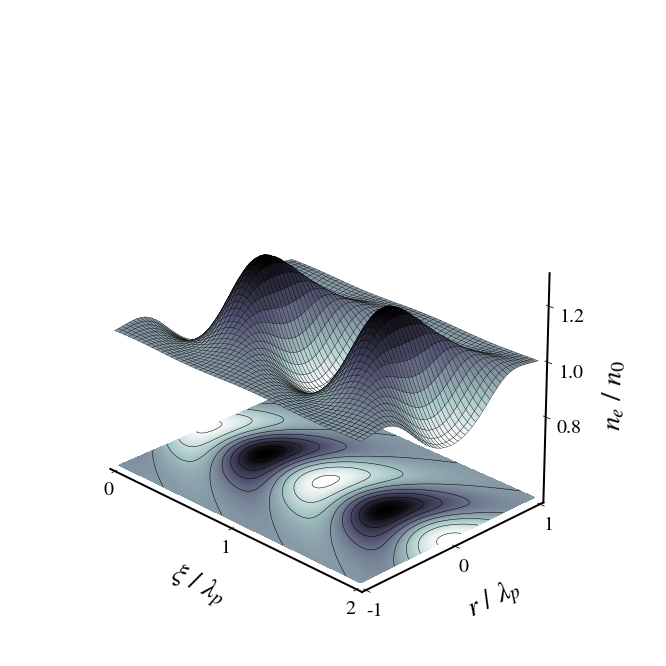

In [4]:
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": "3d"})

ax.plot_surface(grid_xi, grid_r, n, cmap="bone_r", linewidth=0.3, alpha=1.0, edgecolor="black", antialiased=True)
ax.contourf(grid_xi, grid_r, n, zdir='z', offset=0.5, levels=np.linspace(np.min(n), np.max(n), 100), cmap="bone_r")
ax.contour(grid_xi, grid_r, n, zdir='z', offset=0.5, colors="black", linewidths=0.5, linestyles="-")
ax.view_init(25, -45)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.4, 1, 1.3, 1.6]))
ax.set_xlabel(r"$ \xi \ / \ \lambda_p $", fontsize=28, labelpad=40)
ax.set_ylabel(r"$ r \ / \ \lambda_p $", fontsize=28, labelpad=30)
ax.set_zlabel(r"$ n_e \ / \ n_0 $", fontsize=28, labelpad=30)
ax.set_xlim(0, 4.0 * pi)
ax.set_ylim(-2.0 * pi, 2.0 * pi)
ax.set_zlim(0.5, 1.3)
ax.tick_params(labelsize=20)
ax.zaxis.set_tick_params(pad=10)
ax.set_xticks([0.0 * pi, 2.0 * pi, 4.0 * pi])
ax.set_yticks([-2.0 * pi, 0.0, 2.0 * pi])
ax.set_zticks([0.8, 1.0, 1.2])
ax.xaxis.set_ticklabels(["0", "1", "2"])
ax.yaxis.set_ticklabels(["-1", "0", "1"])
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor("white")
ax.yaxis.pane.set_edgecolor("white")
ax.zaxis.pane.set_edgecolor("white")

### Fig. 2

In [5]:
xi, r, k_x, k_r, beta_ph, n_0, a_0, kp_L = sp.symbols("xi, r, k_x, k_r, beta_ph, n_0, a_0, k_{p}L")
n = n_0 * beta_ph / (beta_ph - a_0**2 * sp.exp(-r**2 / kp_L**2) * sp.cos(xi - r**2 / kp_L**2 - sp.pi) / 2)
H = sp.sqrt(k_x**2 + k_r**2 + n) - beta_ph * k_x

In [6]:
dxi_dt = sp.diff(H, k_x)
display(dxi_dt)

-beta_ph + k_x/sqrt(beta_ph*n_0/(a_0**2*exp(-r**2/k_{p}L**2)*cos(xi - r**2/k_{p}L**2)/2 + beta_ph) + k_r**2 + k_x**2)

In [7]:
dr_dxi = sp.diff(H, k_r) / sp.diff(H, k_x)
display(dr_dxi)

k_r/((-beta_ph + k_x/sqrt(beta_ph*n_0/(a_0**2*exp(-r**2/k_{p}L**2)*cos(xi - r**2/k_{p}L**2)/2 + beta_ph) + k_r**2 + k_x**2))*sqrt(beta_ph*n_0/(a_0**2*exp(-r**2/k_{p}L**2)*cos(xi - r**2/k_{p}L**2)/2 + beta_ph) + k_r**2 + k_x**2))

In [8]:
dkx_dxi = -sp.diff(H, xi) / sp.diff(H, k_x)
display(dkx_dxi)

-a_0**2*beta_ph*n_0*exp(-r**2/k_{p}L**2)*sin(xi - r**2/k_{p}L**2)/(4*(-beta_ph + k_x/sqrt(beta_ph*n_0/(a_0**2*exp(-r**2/k_{p}L**2)*cos(xi - r**2/k_{p}L**2)/2 + beta_ph) + k_r**2 + k_x**2))*(a_0**2*exp(-r**2/k_{p}L**2)*cos(xi - r**2/k_{p}L**2)/2 + beta_ph)**2*sqrt(beta_ph*n_0/(a_0**2*exp(-r**2/k_{p}L**2)*cos(xi - r**2/k_{p}L**2)/2 + beta_ph) + k_r**2 + k_x**2))

In [9]:
dkr_dxi = -sp.diff(H, r) / sp.diff(H, k_x)
display(dkr_dxi)

-beta_ph*n_0*(-a_0**2*r*exp(-r**2/k_{p}L**2)*sin(xi - r**2/k_{p}L**2)/k_{p}L**2 + a_0**2*r*exp(-r**2/k_{p}L**2)*cos(xi - r**2/k_{p}L**2)/k_{p}L**2)/(2*(-beta_ph + k_x/sqrt(beta_ph*n_0/(a_0**2*exp(-r**2/k_{p}L**2)*cos(xi - r**2/k_{p}L**2)/2 + beta_ph) + k_r**2 + k_x**2))*(a_0**2*exp(-r**2/k_{p}L**2)*cos(xi - r**2/k_{p}L**2)/2 + beta_ph)**2*sqrt(beta_ph*n_0/(a_0**2*exp(-r**2/k_{p}L**2)*cos(xi - r**2/k_{p}L**2)/2 + beta_ph) + k_r**2 + k_x**2))

In [10]:
dxi_dt_n = sp.lambdify([xi, r, k_x, k_r, beta_ph, n_0, a_0, kp_L], dxi_dt, 'numpy')
dr_dxi_n = sp.lambdify([xi, r, k_x, k_r, beta_ph, n_0, a_0, kp_L], dr_dxi, 'numpy')
dkx_dxi_n = sp.lambdify([xi, r, k_x, k_r, beta_ph, n_0, a_0, kp_L], dkx_dxi, 'numpy')
dkr_dxi_n = sp.lambdify([xi, r, k_x, k_r, beta_ph, n_0, a_0, kp_L], dkr_dxi, 'numpy')

In [11]:
j = 12

a_0 = 0.6
n_0 = 0.01
kp_L = pi
beta_ph = 0.95

xi_0 = np.ones(j) * 0.0
r_0 = np.linspace(-pi, pi, j)
kx_0 = np.ones(j) * 10.0
kr_0 = np.ones(j) * 0.0

sol = []
for i in range(j):
    sol.append(
        solve_ivp(
            lambda q, y: [
                dxi_dt_n(y[0], y[1], y[2], y[3], beta_ph, n_0, a_0, kp_L),
                dr_dxi_n(y[0], y[1], y[2], y[3], beta_ph, n_0, a_0, kp_L),
                dkx_dxi_n(y[0], y[1], y[2], y[3], beta_ph, n_0, a_0, kp_L),
                dkr_dxi_n(y[0], y[1], y[2], y[3], beta_ph, n_0, a_0, kp_L)
            ],
            [0.0, 1000.0],
            [xi_0[i], r_0[i], kx_0[i], kr_0[i]],
            dense_output=True
        )
    )

In [12]:
xi_grid = np.linspace(0.0, 4.0 * pi, 1000)
r_grid = np.linspace(-2.0 * pi, 2.0 * pi, 1000)
grid_xi, grid_r = np.meshgrid(xi_grid, r_grid)
t = np.linspace(0, 1000.0, 10000)
n = beta_ph / (beta_ph - a_0**2 * np.exp(-(grid_r / (kp_L))**2) * np.cos(grid_xi - (grid_r / (kp_L))**2 - pi) / 2.0)

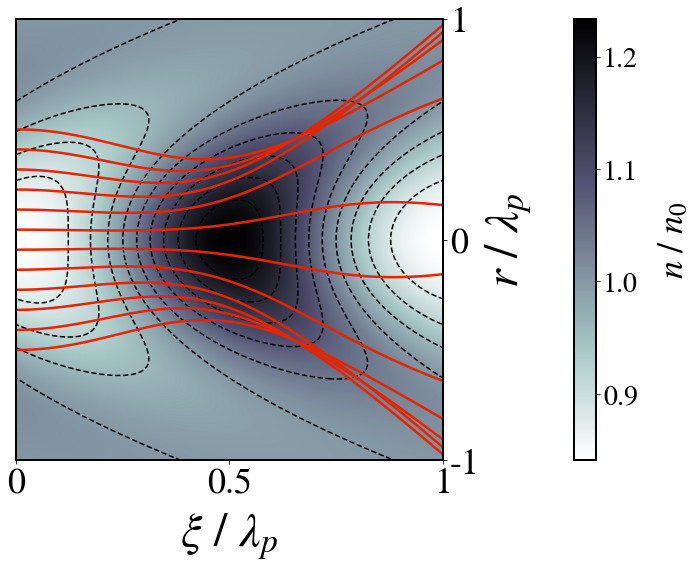

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(grid_xi, grid_r, n, 10, colors="black", linestyles="dashed")
im = ax.pcolormesh(grid_xi, grid_r, n, cmap="bone_r", shading="gouraud")
for s in sol:
    ax.plot(s.sol(t)[0], s.sol(t)[1], linewidth=2.5, color="#e62400")

ax.set_xlim(0.0 * pi, 2.0 * pi)
ax.set_ylim(-2.0 * pi, 2.0 * pi)
ax.set_xlabel(r"$ \xi \ / \ \lambda_p $", fontsize=48, labelpad=10)
ax.set_ylabel(r"$ r \ / \ \lambda_p $", fontsize=48)
ax.tick_params(axis="both", which="major", labelsize=36)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xticks([0.0, pi, 2.0 * pi])
ax.set_yticks([-2.0 * pi, 0.0, 2.0 * pi])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticklabels([-1, 0, 1])

cbar = plt.colorbar(im, ax=ax, aspect=20, pad=0.2)
cbar.set_label(label=r"$ n \ / \ n_0 $", fontsize=36, labelpad=20)
cbar.ax.tick_params(labelsize=28)
cbar.locator = mpl.ticker.MaxNLocator(nbins=5)

fig.tight_layout()

## Sec. III

### Constants

In [14]:
lambda_0 = 1.0e-6
omega_0 = 2.0 * pi * c / lambda_0
T_0 = lambda_0 / c
a_0 = 16.0
w_0 = 6.0 * lambda_0
tau_0 = 12.0 * T_0
n_c = epsilon_0 * m_e * omega_0**2 / elementary_charge**2
n_0 = 0.005 * n_c
omega_pe = np.sqrt(n_0 * elementary_charge**2 / (m_e * epsilon_0))
v_g = c * np.sqrt(1.0  - omega_pe / omega_0)
E_0 = m_e * c * omega_0 * a_0 / elementary_charge
E_p = m_e * c * omega_pe / elementary_charge
E_init = (a_0 / (8.5493e-6 * lambda_0))**2 * w_0**2 * tau_0 / (2.0 * np.sqrt(np.log(2.0))) * (pi / 2.0)**(1.5)

### Custom colormaps

In [15]:
Reds_t = copy.deepcopy(mpl.cm.get_cmap("Reds"))
q = np.linspace(0, Reds_t.N + 3, Reds_t.N + 3)
Reds_t._init()
Reds_t._lut[:,-1] = q / 259

Greens_t = copy.deepcopy(mpl.cm.get_cmap("YlGn"))
q = np.linspace(0, Greens_t.N + 3, Greens_t.N + 3)
Greens_t._init()
Greens_t._lut[:,-1] = q / 259 / 1.25

RdBu_t = copy.deepcopy(mpl.cm.get_cmap("RdBu_r"))
q = np.linspace(0, RdBu_t.N + 3, RdBu_t.N + 3)
RdBu_t._init()
RdBu_t._lut[:,-1] = -0.75 * np.exp(-np.power((q - 128)/20, 2)) + 0.75

### Auxiliary quantities

#### Generate $ u_{\mathrm{EM}}^{2D} (y, z, t) $

In [ ]:
for t in range(140):
    file = sdf.read("./data/main/res_high_{:04d}.sdf".format(t))
    x = file.Grid_Reduced_sub_res_high_mid.data[0]
    y = file.Grid_Reduced_sub_res_high_mid.data[1]
    z = file.Grid_Reduced_sub_res_high_mid.data[2]
    dx = x[1] - x[0]
    ny = np.size(y)
    nz = np.size(z)
    ez = file.Electric_Field_Ez_Reduced_sub_res_high.data
    I = c * epsilon_0 * ez**2
    u_em_2d = np.zeros((ny, nz))
    for i in range(ny):
        for j in range(nz):
            u_em_2d[i, j] = np.sum(I[:, i, j]) * dx / c
    np.save("./data/main/u_em_2d_{:04d}.npy".format(t), u_em_2d)

#### Generate $ u_{\mathrm{EM}}^{1D} (r, t) $

In [ ]:
for t in range(140):
    file = sdf.read("./data/main/res_high_{:04d}.sdf".format(t))
    x = file.Grid_Reduced_sub_res_high_mid.data[0]
    y = file.Grid_Reduced_sub_res_high_mid.data[1]
    z = file.Grid_Reduced_sub_res_high_mid.data[2]
    dx = x[1] - x[0]
    ny = np.size(y)
    nz = np.size(z)
    ez = file.Electric_Field_Ez_Reduced_sub_res_high.data
    I = c * epsilon_0 * ez**2
    u_em_2d_cartesian = np.zeros((ny, nz))
    for i in range(ny):
        for j in range(nz):
            u_em_2d_cartesian[i, j] = np.sum(I[:, i, j]) * dx / c
    y_0 = int(ny / 2)
    z_0 = int(nz / 2)
    r_max = 60.0 * lambda_0
    r_res = int(np.hypot(y_0, z_0))
    theta_res = 360
    r, dr = np.linspace(0.0, r_max, r_res, retstep=True)
    theta, d_theta = np.linspace(0.0, 2.0 * pi, theta_res, retstep=True)
    u_em_2d_polar = np.zeros((r_res, theta_res)) 
    for k in range(theta_res):
        y_1 = y_0 - 1.0 + y_0 * np.cos(theta[k])
        z_1 = z_0 - 1.0 + z_0 * np.sin(theta[k])
        u_em_2d_polar[:, k] = u_em_2d_cartesian[np.linspace(y_0, y_1, r_res).astype(int), np.linspace(z_0, z_1, r_res).astype(int)]  
    u_em_1d = np.sum(u_em_2d_polar, axis=1) * r * d_theta
    np.save("./data/main/u_em_1d_{:04d}.npy".format(t), u_em_1d)

#### Generate $ u_{\mathrm{e}}^{3D} (x, y, z, t) $

In [ ]:
nx = 256
ny = 256
nz = 256
y_ref, dy = np.linspace(-61.0, 61.0, ny, retstep=True)
z_ref, dz = np.linspace(-61.0, 61.0, nz, retstep=True)
for t in range(28):
    print(t)
    ek_total = np.zeros((nx, ny, nz))
    file = sdf.read("./data/main/elns_full_{:04d}.sdf".format(t))
    x = file.Grid_Particles_subset_sub_elns_all_electron.data[0] / lambda_0
    y = file.Grid_Particles_subset_sub_elns_all_electron.data[1] / lambda_0
    z = file.Grid_Particles_subset_sub_elns_all_electron.data[2] / lambda_0
    px = file.Particles_Px_subset_sub_elns_all_electron.data / (m_e * c)
    py = file.Particles_Py_subset_sub_elns_all_electron.data / (m_e * c)
    pz = file.Particles_Pz_subset_sub_elns_all_electron.data / (m_e * c)
    weight = file.Particles_Weight_subset_sub_elns_all_electron.data
    ek = np.sqrt(1.0 + px**2 + py**2 + pz**2) - 1.0
    x_ref, dx = np.linspace(10.0 + (t - 1) * 50.0 - 1.0, 90.0 + (t - 1) * 50.0 + 1.0, nx, retstep=True)
    for i in range(np.size(ek)):
        ind_x = np.where(x_ref >= x[i])[0][0]
        ind_y = np.where(y_ref >= y[i])[0][0]
        ind_z = np.where(z_ref >= z[i])[0][0]
        ek_total[ind_x, ind_y, ind_z] += ek[i] * weight[i]
    u_e_3d = ek_total / (dx * dy * dz)
    np.save("./data/main/u_e_3d_{:04d}.npy".format(t), u_e_3d)

#### Generate $ u_{\mathrm{e}}^{2D} (y, z, t) $

In [ ]:
ny = 2048
nz = 2048
y_ref, dy = np.linspace(-61, 61, ny, retstep=True)
z_ref, dz = np.linspace(-61, 61, nz, retstep=True)
for t in range(28):
    ek_total = np.zeros((ny, nz))
    file = sdf.read("./data/main/elns_full_{:04d}.sdf".format(t))
    y = file.Grid_Particles_subset_sub_elns_all_electron.data[1] / lambda_0
    z = file.Grid_Particles_subset_sub_elns_all_electron.data[2] / lambda_0
    px = file.Particles_Px_subset_sub_elns_all_electron.data / (m_e * c)
    py = file.Particles_Py_subset_sub_elns_all_electron.data / (m_e * c)
    pz = file.Particles_Pz_subset_sub_elns_all_electron.data / (m_e * c)
    weight = file.Particles_Weight_subset_sub_elns_all_electron.data
    ek = np.sqrt(1.0 + px**2 + py**2 + pz**2) - 1.0
    for i in range(np.size(ek)):
        ind_y = np.where(y_ref >= y[i])[0][0]
        ind_z = np.where(z_ref >= z[i])[0][0]
        ek_total[ind_y, ind_z] += ek[i] * weight[i]
    u_e_2d = ek_total / (dy * dz)
    np.save("./data/main/u_e_2d_{:04d}.npy".format(t), u_e_2d)

### Fig. 3

In [18]:
file = sdf.read("./data/main/slice_xy_0079.sdf")
ne_xy_1 = np.sum(file.Derived_Number_Density_subset_sub_slice_xy_electron.data / n_c, axis=2) / 2.0
ez_xy_1 = np.sum(file.Electric_Field_Ez_Core_sub_slice_xy.data / E_0, axis=2) / 2.0
grid_x_1 = file.Grid_sub_slice_xy.data[0] / lambda_0
grid_y_1 = file.Grid_sub_slice_xy.data[1] / lambda_0

file = sdf.read("./data/main/slice_xz_0079.sdf")
ne_xz_1 = np.sum(file.Derived_Number_Density_subset_sub_slice_xz_electron.data / n_c, axis=1) / 2.0
ez_xz_1 = np.sum(file.Electric_Field_Ez_Core_sub_slice_xz.data / E_0, axis=1) / 2.0
grid_x_1 = file.Grid_sub_slice_xz.data[0] / lambda_0
grid_z_1 = file.Grid_sub_slice_xz.data[2] / lambda_0

file = sdf.read("./data/main/slice_xy_0119.sdf")
ne_xy_2 = np.sum(file.Derived_Number_Density_subset_sub_slice_xy_electron.data / n_c, axis=2) / 2.0
ez_xy_2 = np.sum(file.Electric_Field_Ez_Core_sub_slice_xy.data / E_0, axis=2) / 2.0
grid_x_2 = file.Grid_sub_slice_xy.data[0] / lambda_0
grid_y_2 = file.Grid_sub_slice_xy.data[1] / lambda_0

file = sdf.read("./data/main/slice_xz_0119.sdf")
ne_xz_2 = np.sum(file.Derived_Number_Density_subset_sub_slice_xz_electron.data / n_c, axis=1) / 2.0
ez_xz_2 = np.sum(file.Electric_Field_Ez_Core_sub_slice_xz.data / E_0, axis=1) / 2.0
grid_x_2 = file.Grid_sub_slice_xz.data[0] / lambda_0
grid_z_2 = file.Grid_sub_slice_xz.data[2] / lambda_0

file = sdf.read("./data/main/slice_xy_0159.sdf")
ne_xy_3 = np.sum(file.Derived_Number_Density_subset_sub_slice_xy_electron.data / n_c, axis=2) / 2.0
ez_xy_3 = np.sum(file.Electric_Field_Ez_Core_sub_slice_xy.data / E_0, axis=2) / 2.0
grid_x_3 = file.Grid_sub_slice_xy.data[0] / lambda_0
grid_y_3 = file.Grid_sub_slice_xy.data[1] / lambda_0

file = sdf.read("./data/main/slice_xz_0159.sdf")
ne_xz_3 = np.sum(file.Derived_Number_Density_subset_sub_slice_xz_electron.data / n_c, axis=1) / 2.0
ez_xz_3 = np.sum(file.Electric_Field_Ez_Core_sub_slice_xz.data / E_0, axis=1) / 2.0
grid_x_3 = file.Grid_sub_slice_xz.data[0] / lambda_0
grid_z_3 = file.Grid_sub_slice_xz.data[2] / lambda_0

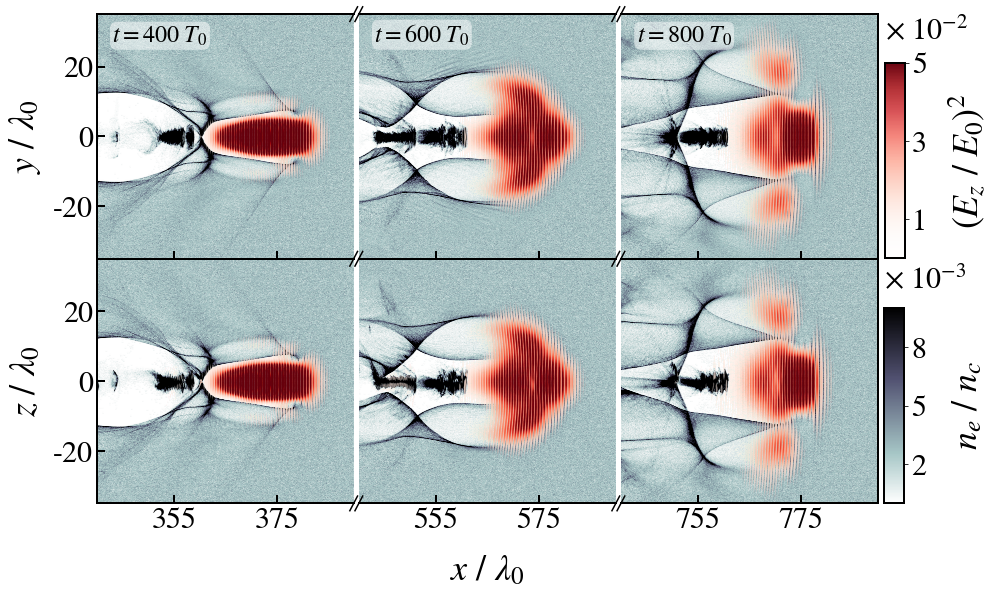

In [19]:
d = 3.0e-2
label_size = 36
tick_size = 30
text_size = 24

fig, ax = plt.subplots(2, 3, figsize=(14, 9))

im_ne_xy_1 = ax[0, 0].pcolormesh(grid_x_1[0:-1], grid_y_1[0:-1], ne_xy_1.T, cmap="bone_r", shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.01))
im_ez_xy_1 = ax[0, 0].pcolormesh(grid_x_1[0:-1], grid_y_1[0:-1], ez_xy_1.T**2, cmap=Reds_t, shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.05))
ax[0, 0].set_xlim(grid_x_1.max() - 50, grid_x_1.max())
ax[0, 0].set_ylim(grid_y_1.min() + 25, grid_y_1.max() - 25)
ax[0, 0].set_xticks([355, 375])
ax[0, 0].set_yticks([-20, 0, 20])
ax[0, 0].set_xticklabels([])
ax[0, 0].set_yticklabels([-20, 0, 20])
ax[0, 0].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].plot((1-d/2,1+d/2),(1-d,1+d), transform=ax[0, 0].transAxes, color='k', clip_on=False)
ax[0, 0].text(343, 27, r"$ t = 400 \ T_0 $", color="black", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.5, boxstyle="round, pad=0.1, rounding_size=0.3"))
ax[0, 0].set_ylabel(r"$ y \ / \ \lambda_0 $", fontsize=label_size, labelpad=10)

im_ne_xy_2 = ax[0, 1].pcolormesh(grid_x_2[0:-1], grid_y_2[0:-1], ne_xy_2.T, cmap="bone_r", shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.01))
im_ez_xy_2 = ax[0, 1].pcolormesh(grid_x_2[0:-1], grid_y_2[0:-1], ez_xy_2.T**2, cmap=Reds_t, shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.05))
ax[0, 1].set_xlim(grid_x_2.max() - 50, grid_x_2.max())
ax[0, 1].set_ylim(grid_y_2.min() + 25, grid_y_2.max() - 25)
ax[0, 1].set_xticks([555, 575])
ax[0, 1].set_yticks([])
ax[0, 1].set_xticklabels([])
ax[0, 1].set_yticklabels([])
ax[0, 1].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[0, 1].spines['left'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].plot((-d/2,+d/2), (1-d,1+d), transform=ax[0, 1].transAxes, color='k', clip_on=False)
ax[0, 1].plot((1-d/2,1+d/2),(1-d,1+d), transform=ax[0, 1].transAxes, color='k', clip_on=False)
ax[0, 1].text(543, 27, r"$ t = 600 \ T_0 $", color="black", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.5, boxstyle="round, pad=0.1, rounding_size=0.3"))

im_ne_xy_3 = ax[0, 2].pcolormesh(grid_x_3[0:-1], grid_y_3[0:-1], ne_xy_3.T, cmap="bone_r", shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.01))
im_ez_xy_3 = ax[0, 2].pcolormesh(grid_x_3[0:-1], grid_y_3[0:-1], ez_xy_3.T**2, cmap=Reds_t, shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.05))
ax[0, 2].set_xlim(grid_x_3.max() - 50, grid_x_3.max())
ax[0, 2].set_ylim(grid_y_3.min() + 25, grid_y_3.max() - 25)
ax[0, 2].set_xticks([755, 775])
ax[0, 2].set_yticks([])
ax[0, 2].set_xticklabels([])
ax[0, 2].set_yticklabels([])
ax[0, 2].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[0, 2].spines['left'].set_visible(False)
ax[0, 2].plot((-d/2,+d/2), (1-d,1+d), transform=ax[0, 2].transAxes, color='k', clip_on=False)
ax[0, 2].text(743, 27, r"$ t = 800 \ T_0 $", color="black", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.5, boxstyle="round, pad=0.1, rounding_size=0.3"))

im_ne_xz_1 = ax[1, 0].pcolormesh(grid_x_1[0:-1], grid_z_1[0:-1], ne_xz_1.T, cmap="bone_r", shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.01))
im_ez_xz_1 = ax[1, 0].pcolormesh(grid_x_1[0:-1], grid_z_1[0:-1], ez_xz_1.T**2, cmap=Reds_t, shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.05))
ax[1, 0].set_xlim(grid_x_1.max() - 50, grid_x_1.max())
ax[1, 0].set_ylim(grid_z_1.min() + 25, grid_z_1.max() - 25)
ax[1, 0].set_xticks([355, 375])
ax[1, 0].set_yticks([-20, 0, 20])
ax[1, 0].set_xticklabels([355, 375])
ax[1, 0].set_yticklabels([-20, 0, 20])
ax[1, 0].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].plot((1-d/2,1+d/2), (-d,+d), transform=ax[1, 0].transAxes, color='k', clip_on=False)
ax[1, 0].plot((1-d/2,1+d/2),(1-d,1+d), transform=ax[1, 0].transAxes, color='k', clip_on=False)
ax[1, 0].set_ylabel(r"$ z \ / \ \lambda_0 $", fontsize=label_size, labelpad=10)

im_ne_xz_2 = ax[1, 1].pcolormesh(grid_x_2[0:-1], grid_z_2[0:-1], ne_xz_2.T, cmap="bone_r", shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.01))
im_ez_xz_2 = ax[1, 1].pcolormesh(grid_x_2[0:-1], grid_z_2[0:-1], ez_xz_2.T**2, cmap=Reds_t, shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.05))
ax[1, 1].set_xlim(grid_x_2.max() - 50, grid_x_2.max())
ax[1, 1].set_ylim(grid_z_2.min() + 25, grid_z_2.max() - 25)
ax[1, 1].set_xticks([555, 575])
ax[1, 1].set_yticks([])
ax[1, 1].set_xticklabels([555, 575])
ax[1, 1].set_yticklabels([])
ax[1, 1].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[1, 1].spines['left'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)
ax[1, 1].plot((-d/2,+d/2), (1-d,1+d), transform=ax[1, 1].transAxes, color='k', clip_on=False)
ax[1, 1].plot((-d/2,+d/2), (-d,+d), transform=ax[1, 1].transAxes, color='k', clip_on=False)
ax[1, 1].plot((1-d/2,1+d/2), (-d,+d), transform=ax[1, 1].transAxes, color='k', clip_on=False)
ax[1, 1].plot((1-d/2,1+d/2),(1-d,1+d), transform=ax[1, 1].transAxes, color='k', clip_on=False)
ax[1, 1].set_xlabel(r"$ x \ / \ \lambda_0 $", fontsize=label_size, labelpad=20)

im_ne_xz_3 = ax[1, 2].pcolormesh(grid_x_3[0:-1], grid_z_3[0:-1], ne_xz_3.T, cmap="bone_r", shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.01))
im_ez_xz_3 = ax[1, 2].pcolormesh(grid_x_3[0:-1], grid_z_3[0:-1], ez_xz_3.T**2, cmap=Reds_t, shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.05))
ax[1, 2].set_xlim(grid_x_3.max() - 50, grid_x_3.max())
ax[1, 2].set_ylim(grid_z_3.min() + 25, grid_z_3.max() - 25)
ax[1, 2].set_xticks([755, 775])
ax[1, 2].set_yticks([])
ax[1, 2].set_xticklabels([755, 775])
ax[1, 2].set_yticklabels([])
ax[1, 2].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[1, 2].spines['left'].set_visible(False)
ax[1, 2].plot((-d/2,+d/2), (1-d,1+d), transform=ax[1, 2].transAxes, color='k', clip_on=False)
ax[1, 2].plot((-d/2,+d/2), (-d,+d), transform=ax[1, 2].transAxes, color='k', clip_on=False)

cbar_1 = plt.colorbar(im_ez_xy_3, ax=ax[:, 2], aspect=10, ticks=[1.0e-2, 3.0e-2, 5.0e-2], anchor=(2.8, 0.835), shrink=0.4)
cbar_1.set_label(label=r"$ \left( E_z \ / \ E_0 \right)^{2} $", fontsize=label_size, labelpad=20)
cbar_1.ax.tick_params(labelsize=tick_size)
cbar_1.formatter.set_powerlimits((0, 0))
cbar_1.ax.yaxis.offsetText.set_visible(False)
cbar_1.ax.text(0.0, 0.056, r'$ \times \ 10^{-2} $', fontsize=tick_size)
cbar_1.update_ticks()

cbar_2 = plt.colorbar(im_ne_xy_3, ax=ax[:, 2], aspect=10, ticks=[2.0e-3, 5.0e-3, 8.0e-3], anchor=(10.0, 0.0), shrink=0.4)
cbar_2.set_label(label=r"$ n_e \ / \ n_c $", fontsize=label_size, labelpad=25)
cbar_2.ax.tick_params(labelsize=tick_size)
cbar_2.formatter.set_powerlimits((0, 0))
cbar_2.ax.yaxis.offsetText.set_visible(False)
cbar_2.ax.text(0.0, 0.011, r'$ \times \ 10^{-3} $', fontsize=tick_size)
cbar_2.update_ticks()

fig.subplots_adjust(wspace=0.02)
fig.subplots_adjust(hspace=0.0)

### Fig. 4

In [20]:
file = sdf.read("./data/main/slice_xy_0199.sdf")
ne_xy = np.sum(file.Derived_Number_Density_subset_sub_slice_xy_electron.data / n_c, axis=2) / 2.0
ez_xy = np.sum(file.Electric_Field_Ez_Core_sub_slice_xy.data / E_0, axis=2) / 2.0
grid_x = file.Grid_sub_slice_xy.data[0] / lambda_0
grid_y = file.Grid_sub_slice_xy.data[1] / lambda_0

file = sdf.read("./data/main/slice_xz_0199.sdf")
ne_xz = np.sum(file.Derived_Number_Density_subset_sub_slice_xz_electron.data / n_c, axis=1) / 2.0
ez_xz = np.sum(file.Electric_Field_Ez_Core_sub_slice_xz.data / E_0, axis=1) / 2.0
grid_x = file.Grid_sub_slice_xz.data[0] / lambda_0
grid_z = file.Grid_sub_slice_xz.data[2] / lambda_0

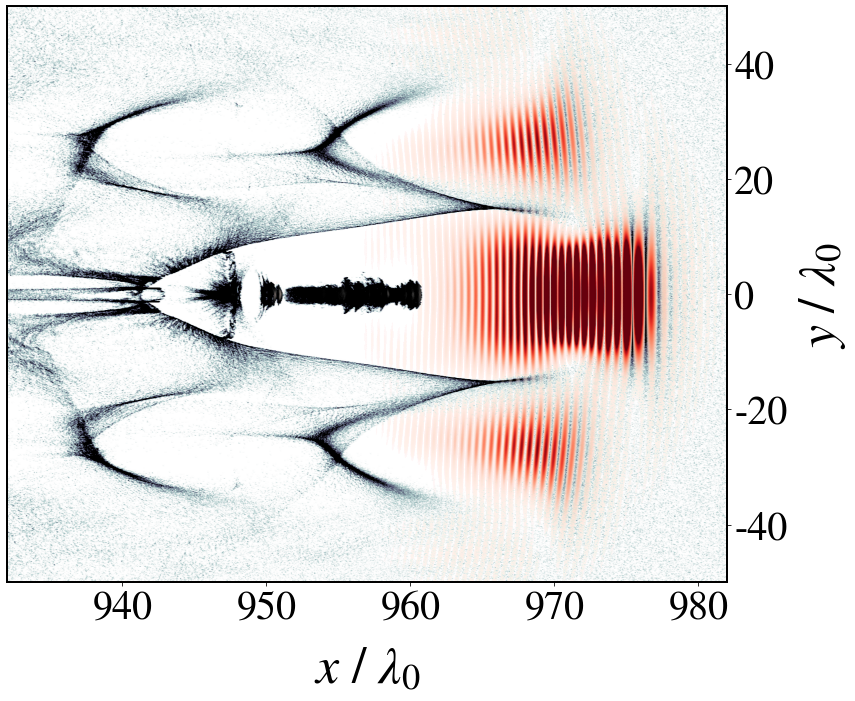

In [21]:
fig = plt.figure()

h = [Size.Fixed(1.0), Size.Fixed(10.0)]
v = [Size.Fixed(1.0), Size.Fixed(8.0)]

divider = Divider(fig, (0.0, 0.0, 1., 1.), h, v, aspect=False)
ax = Axes(fig, divider.get_position())
ax.set_axes_locator(divider.new_locator(nx=1, ny=1))
fig.add_axes(ax)

im_ne_xy = ax.pcolormesh(grid_x[0:-1], grid_y[0:-1], ne_xy.T, cmap="bone_r", shading="gouraud", norm=mpl.colors.Normalize(0.0025, 0.01))
im_ez_xy = ax.pcolormesh(grid_x[0:-1], grid_y[0:-1], ez_xy.T**2, cmap=Reds_t, shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.02))
ax.set_xlim(932, 982)
ax.set_ylim(-50, 50)
ax.set_xticks([940, 950, 960, 970, 980])
ax.set_yticks([-40, -20, 0, 20, 40])
ax.set_xticklabels([940, 950, 960, 970, 980])
ax.set_yticklabels([-40, -20, 0, 20, 40])
ax.tick_params(axis="both", which="major", labelsize=40)
ax.set_xlabel(r"$ x \ / \ \lambda_0 $", fontsize=52, labelpad=20)
ax.set_ylabel(r"$ y \ / \ \lambda_0 $", fontsize=52, labelpad=10)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

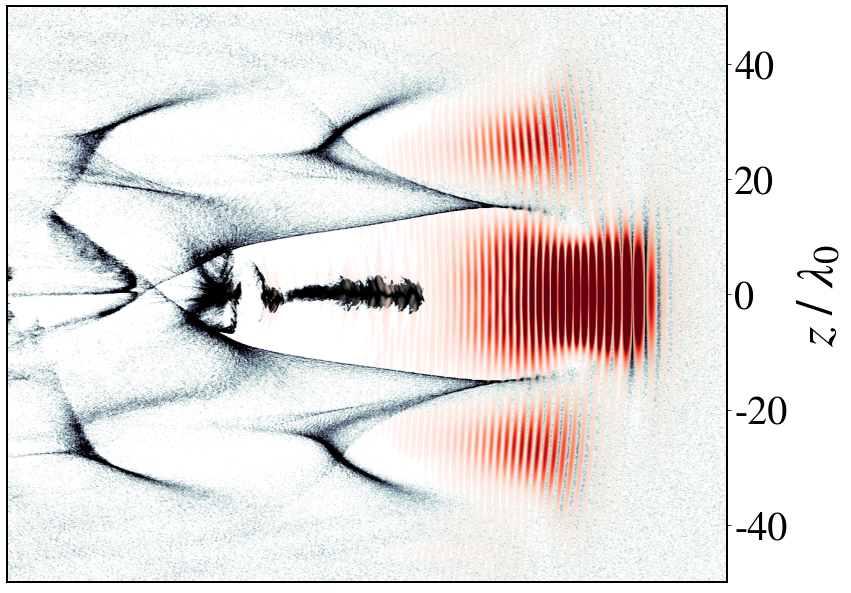

In [22]:
fig = plt.figure()

h = [Size.Fixed(1.0), Size.Fixed(10.0)]
v = [Size.Fixed(1.0), Size.Fixed(8.0)]

divider = Divider(fig, (0.0, 0.0, 1., 1.), h, v, aspect=False)
ax = Axes(fig, divider.get_position())
ax.set_axes_locator(divider.new_locator(nx=1, ny=1))
fig.add_axes(ax)

im_ne_xz = ax.pcolormesh(grid_x[0:-1], grid_z[0:-1], ne_xz.T, cmap="bone_r", shading="gouraud", norm=mpl.colors.Normalize(0.0025, 0.01))
im_ez_xz = ax.pcolormesh(grid_x[0:-1], grid_z[0:-1], ez_xz.T**2, cmap=Reds_t, shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.02))
ax.set_xlim(932, 982)
ax.set_ylim(-50, 50)
ax.set_xticks([])
ax.set_yticks([-40, -20, 0, 20, 40])
ax.set_xticklabels([])
ax.set_yticklabels([-40, -20, 0, 20, 40])
ax.tick_params(axis="both", which="major", labelsize=40)
ax.set_ylabel(r"$ z \ / \ \lambda_0 $", fontsize=52, labelpad=10)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

### Fig. 5

In [23]:
times = [69, 79, 89, 99, 109, 119]
y = np.linspace(-60.0 * lambda_0, 60.0 * lambda_0, 600)
z = np.linspace(-60.0 * lambda_0, 60.0 * lambda_0, 600)
u_em_2d_1 = np.load("./data/main/u_em_2d_{:04d}.npy".format(times[0]))
u_em_2d_2 = np.load("./data/main/u_em_2d_{:04d}.npy".format(times[1]))
u_em_2d_3 = np.load("./data/main/u_em_2d_{:04d}.npy".format(times[2]))
u_em_2d_4 = np.load("./data/main/u_em_2d_{:04d}.npy".format(times[3]))
u_em_2d_5 = np.load("./data/main/u_em_2d_{:04d}.npy".format(times[4]))
u_em_2d_6 = np.load("./data/main/u_em_2d_{:04d}.npy".format(times[5]))

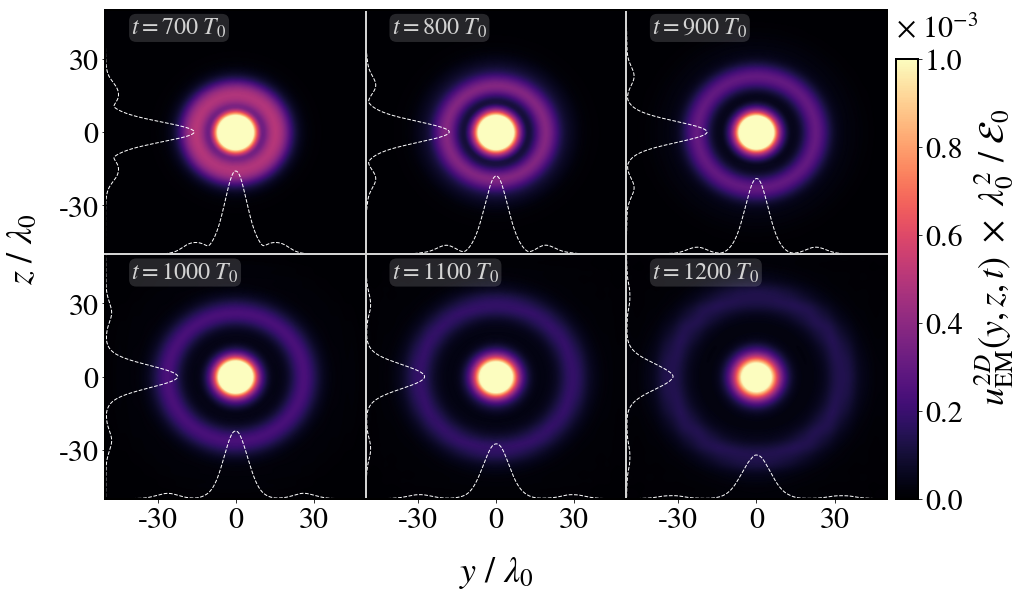

In [24]:
label_size = 36
tick_size = 30
text_size = 24

fig, ax = plt.subplots(2, 3, figsize=(14, 9))

im_1 = ax[0, 0].pcolormesh(y / lambda_0, z / lambda_0, u_em_2d_1.T * lambda_0**2 / E_init, cmap="magma", shading="gouraud", norm=mpl.colors.Normalize(0.0, 1.0e-3))
ax[0, 0].set_xlim(-50, 50)
ax[0, 0].set_ylim(-50, 50)
ax[0, 0].set_xticks([-30, 0, 30])
ax[0, 0].set_yticks([-30, 0, 30])
ax[0, 0].set_xticklabels([])
ax[0, 0].set_yticklabels([-30, 0, 30])
ax_y_0 = ax[0, 0].twinx()
ax_y_0.plot(y / lambda_0, u_em_2d_1.T[:, 300] * lambda_0**2 / E_init, color="white", linestyle="--", linewidth=1.0)
ax_y_0.set_xlim(-50, 50)
ax_y_0.set_ylim(0, 0.01)
ax_y_0.get_yaxis().set_ticks([])
ax_z_0 = ax[0, 0].twiny()
ax_z_0.plot(u_em_2d_1.T[300, :] * lambda_0**2 / E_init, z / lambda_0, color="white", linestyle="--", linewidth=1.0)
ax_z_0.set_ylim(-50, 50)
ax_z_0.set_xlim(0, 0.01)
ax_z_0.get_xaxis().set_ticks([])
ax[0, 0].tick_params(axis="both", which="major", labelsize=tick_size)
ax[0, 0].text(-40, 40, r"$ t = 700 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
for s in ["right", "bottom"]:
    ax_z_0.spines[s].set_color("lightgray")

im_2 = ax[0, 1].pcolormesh(y / lambda_0, z / lambda_0, u_em_2d_2.T * lambda_0**2 / E_init, cmap="magma", shading="gouraud", norm=mpl.colors.Normalize(0.0, 1.0e-3))
ax[0, 1].set_xlim(-50, 50)
ax[0, 1].set_ylim(-50, 50)
ax[0, 1].set_xticks([-30, 0, 30])
ax[0, 1].set_yticks([-30, 0, 30])
ax[0, 1].set_xticklabels([])
ax[0, 1].set_yticklabels([])
ax_y_1 = ax[0, 1].twinx()
ax_y_1.plot(y / lambda_0, u_em_2d_2.T[:, 300] * lambda_0**2 / E_init, color="white", linestyle="--", linewidth=1.0)
ax_y_1.set_xlim(-50, 50)
ax_y_1.set_ylim(0, 0.01)
ax_y_1.get_yaxis().set_ticks([])
ax_z_1 = ax[0, 1].twiny()
ax_z_1.plot(u_em_2d_2.T[300, :] * lambda_0**2 / E_init, z / lambda_0, color="white", linestyle="--", linewidth=1.0)
ax_z_1.set_ylim(-50, 50)
ax_z_1.set_xlim(0, 0.01)
ax_z_1.get_xaxis().set_ticks([])
ax[0, 1].tick_params(axis="both", which="major", labelsize=tick_size)
ax[0, 1].text(-40, 40, r"$ t = 800 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
for s in ["left", "right", "bottom"]:
    ax_z_1.spines[s].set_color("lightgray")

im_3 = ax[0, 2].pcolormesh(y / lambda_0, z / lambda_0, u_em_2d_3.T * lambda_0**2 / E_init, cmap="magma", shading="gouraud", norm=mpl.colors.Normalize(0.0, 1.0e-3))
ax[0, 2].set_xlim(-50, 50)
ax[0, 2].set_ylim(-50, 50)
ax[0, 2].set_xticks([-30, 0, 30])
ax[0, 2].set_yticks([-30, 0, 30])
ax[0, 2].set_xticklabels([])
ax[0, 2].set_yticklabels([])
ax_y_2 = ax[0, 2].twinx()
ax_y_2.plot(y / lambda_0, u_em_2d_3.T[:, 300] * lambda_0**2 / E_init, color="white", linestyle="--", linewidth=1.0)
ax_y_2.set_xlim(-50, 50)
ax_y_2.set_ylim(0, 0.01)
ax_y_2.get_yaxis().set_ticks([])
ax_z_2 = ax[0, 2].twiny()
ax_z_2.plot(u_em_2d_3.T[300, :] * lambda_0**2 / E_init, z / lambda_0, color="white", linestyle="--", linewidth=1.0)
ax_z_2.set_ylim(-50, 50)
ax_z_2.set_xlim(0, 0.01)
ax_z_2.get_xaxis().set_ticks([])
ax[0, 2].tick_params(axis="both", which="major", labelsize=tick_size)
ax[0, 2].text(-40, 40, r"$ t = 900 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
for s in ["left", "bottom"]:
    ax_z_2.spines[s].set_color("lightgray")

im_4 = ax[1, 0].pcolormesh(y / lambda_0, z / lambda_0, u_em_2d_4.T * lambda_0**2 / E_init, cmap="magma", shading="gouraud", norm=mpl.colors.Normalize(0.0, 1.0e-3))
ax[1, 0].set_xlim(-50, 50)
ax[1, 0].set_ylim(-50, 50)
ax[1, 0].set_xticks([-30, 0, 30])
ax[1, 0].set_yticks([-30, 0, 30])
ax[1, 0].set_xticklabels([-30, 0, 30])
ax[1, 0].set_yticklabels([-30, 0, 30])
ax_y_3 = ax[1, 0].twinx()
ax_y_3.plot(y / lambda_0, u_em_2d_4.T[:, 300] * lambda_0**2 / E_init, color="white", linestyle="--", linewidth=1.0)
ax_y_3.set_xlim(-50, 50)
ax_y_3.set_ylim(0, 0.01)
ax_y_3.get_yaxis().set_ticks([])
ax_z_3 = ax[1, 0].twiny()
ax_z_3.plot(u_em_2d_4.T[300, :] * lambda_0**2 / E_init, z / lambda_0, color="white", linestyle="--", linewidth=1.0)
ax_z_3.set_ylim(-50, 50)
ax_z_3.set_xlim(0, 0.01)
ax_z_3.get_xaxis().set_ticks([])
ax[1, 0].tick_params(axis="both", which="major", labelsize=tick_size)
ax[1, 0].text(-40, 40, r"$ t = 1000 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
ax[1, 0].set_ylabel(r"$ z \ / \ \lambda_0 $", fontsize=label_size, labelpad=20)
ax[1, 0].yaxis.set_label_coords(-0.25, 1.025)
for s in ["right", "top"]:
    ax_z_3.spines[s].set_color("lightgray")

im_5 = ax[1, 1].pcolormesh(y / lambda_0, z / lambda_0, u_em_2d_5.T * lambda_0**2 / E_init, cmap="magma", shading="gouraud", norm=mpl.colors.Normalize(0.0, 1.0e-3))
ax[1, 1].set_xlim(-50, 50)
ax[1, 1].set_ylim(-50, 50)
ax[1, 1].set_xticks([-30, 0, 30])
ax[1, 1].set_yticks([-30, 0, 30])
ax[1, 1].set_xticklabels([-30, 0, 30])
ax[1, 1].set_yticklabels([])
ax_y_4 = ax[1, 1].twinx()
ax_y_4.plot(y / lambda_0, u_em_2d_5.T[:, 300] * lambda_0**2 / E_init, color="white", linestyle="--", linewidth=1.0)
ax_y_4.set_xlim(-50, 50)
ax_y_4.set_ylim(0, 0.01)
ax_y_4.get_yaxis().set_ticks([])
ax_z_4 = ax[1, 1].twiny()
ax_z_4.plot(u_em_2d_5.T[300, :] * lambda_0**2 / E_init, z / lambda_0, color="white", linestyle="--", linewidth=1.0)
ax_z_4.set_ylim(-50, 50)
ax_z_4.set_xlim(0, 0.01)
ax_z_4.get_xaxis().set_ticks([])
ax[1, 1].tick_params(axis="both", which="major", labelsize=tick_size)
ax[1, 1].text(-40, 40, r"$ t = 1100 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
ax[1, 1].set_xlabel(r"$ y \ / \ \lambda_0 $", fontsize=label_size, labelpad=20)
for s in ["left", "right", "top"]:
    ax_z_4.spines[s].set_color("lightgray")

im_6 = ax[1, 2].pcolormesh(y / lambda_0, z / lambda_0, u_em_2d_6.T * lambda_0**2 / E_init, cmap="magma", shading="gouraud", norm=mpl.colors.Normalize(0.0, 1.0e-3))
ax[1, 2].set_xlim(-50, 50)
ax[1, 2].set_ylim(-50, 50)
ax[1, 2].set_xticks([-30, 0, 30])
ax[1, 2].set_yticks([-30, 0, 30])
ax[1, 2].set_xticklabels([-30, 0, 30])
ax[1, 2].set_yticklabels([])
ax_y_5 = ax[1, 2].twinx()
ax_y_5.plot(y / lambda_0, u_em_2d_6.T[:, 300] * lambda_0**2 / E_init, color="white", linestyle="--", linewidth=1.0)
ax_y_5.set_xlim(-50, 50)
ax_y_5.set_ylim(0, 0.01)
ax_y_5.get_yaxis().set_ticks([])
ax_z_5 = ax[1, 2].twiny()
ax_z_5.plot(u_em_2d_6.T[300, :] * lambda_0**2 / E_init, z / lambda_0, color="white", linestyle="--", linewidth=1.0)
ax_z_5.set_ylim(-50, 50)
ax_z_5.set_xlim(0, 0.01)
ax_z_5.get_xaxis().set_ticks([])
ax[1, 2].tick_params(axis="both", which="major", labelsize=tick_size)
ax[1, 2].text(-40, 40, r"$ t = 1200 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
for s in ["left", "top"]:
    ax_z_5.spines[s].set_color("lightgray")

cbar = plt.colorbar(im_3, ax=ax[:, 2], aspect=20, anchor=(3.5, 0.0), shrink=0.9)
cbar.set_label(label=r"$ u_{\mathrm{EM}}^{2D} (y, z, t) \ \times \ \lambda_0^2 \ / \ \mathcal{E}_0 $", fontsize=label_size, labelpad=0)
cbar.ax.tick_params(labelsize=tick_size)
cbar.locator = mpl.ticker.MaxNLocator(nbins=6)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set_visible(False)
cbar.ax.text(0.0, 1.05e-3, r'$ \times \ 10^{-3} $', fontsize=tick_size)
cbar.update_ticks()
cbar.ax.yaxis.set_label_coords(3.5, 0.55)

fig.subplots_adjust(wspace=0.0)
fig.subplots_adjust(hspace=0.0)

### Fig. 6

In [25]:
r = np.linspace(0.0 * lambda_0, 60.0 * lambda_0, int(np.hypot(300, 300)))
verts = []
colors = []
linewidths = []
r_0_time = np.zeros(150)
r_1_time = np.zeros(150)
u_em_1d_r0 = np.zeros(150)
u_em_1d_r1 = np.zeros(150)
for t in range(58, 119):
    u_em_1d = np.load("./data/main/u_em_1d_{:04d}.npy".format(t))
    r_0 = find_peaks(-u_em_1d, width=5)[0][0]
    r_1 = find_peaks(u_em_1d, width=5)[0][1]
    r_0_time[t] = r_0
    r_1_time[t] = r_1
    u_em_1d_r0[t] = u_em_1d[r_0]
    u_em_1d_r1[t] = u_em_1d[r_1]
    verts.append(list(zip(r / lambda_0, u_em_1d * lambda_0 / E_init)))
    if t == 99:
        colors.append("blue")
        linewidths.append(2)
    else:
        colors.append("black")
        linewidths.append(1)

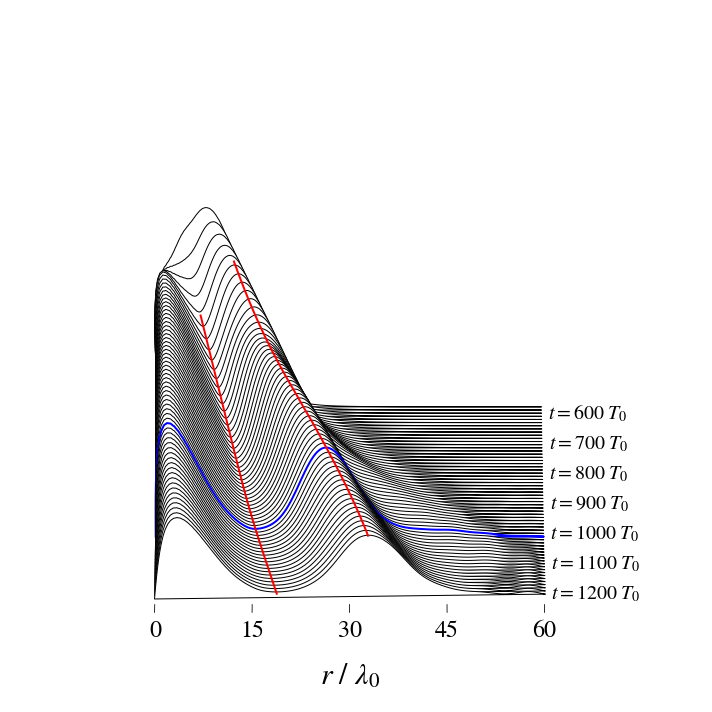

In [26]:
fig, ax = plt.subplots(figsize=(10, 12), subplot_kw={"projection": "3d"})
poly = mpl.collections.PolyCollection(verts, alpha=1.0, edgecolor=colors, facecolor="white", linewidths=linewidths)
zs = np.linspace(2.5, 0, 61)
ax.add_collection3d(poly, zs=zs, zdir="y")
ax.plot(savgol_filter(r[r_0_time[62:119].astype(int)], 51, 3) / lambda_0, savgol_filter(u_em_1d_r0[62:119], 51, 3) * lambda_0 / E_init, zs=zs[4:], zdir="y", color="red", linestyle="-", linewidth=2, zorder=3)
ax.plot(savgol_filter(r[r_1_time[62:119].astype(int)], 51, 3) / lambda_0, savgol_filter(u_em_1d_r1[62:119], 51, 3) * lambda_0 / E_init, zs=zs[4:], zdir="y", color="red", linestyle="-", linewidth=2, zorder=3)
ax.view_init(70.0, -90.0)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.2, 1.0, 1.2, 1.3]))
ax.set_xlim(0.0, 60.0)
ax.set_ylim(0.0, 4.0)
ax.set_zlim(0.0, 0.04)
ax.set_xticks([0, 15, 30, 45, 60])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel(r"$ r \ / \ \lambda_0 $", fontsize=30, labelpad=40)
ax.tick_params(axis="x", labelsize=24, width=10)
ax.text(61.0, 2.34, 0.0, r"$ t = 600 \ T_0 $", color="black", fontsize=20)
ax.text(61.0, 1.95, 0.0, r"$ t = 700 \ T_0 $", color="black", fontsize=20)
ax.text(61.0, 1.56, 0.0, r"$ t = 800 \ T_0 $", color="black", fontsize=20)
ax.text(61.0, 1.17, 0.0, r"$ t = 900 \ T_0 $", color="black", fontsize=20)
ax.text(61.0, 0.78, 0.0, r"$ t = 1000 \ T_0 $", color="black", fontsize=20)
ax.text(61.0, 0.39, 0.0, r"$ t = 1100 \ T_0 $", color="black", fontsize=20)
ax.text(61.0, 0.00, 0.0, r"$ t = 1200 \ T_0 $", color="black", fontsize=20)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor("white")
ax.yaxis.pane.set_edgecolor("white")
ax.zaxis.pane.set_edgecolor("white")
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
fig.tight_layout()

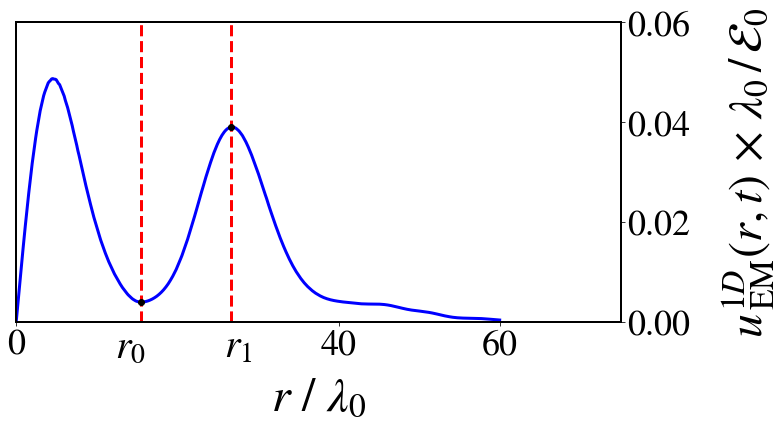

In [27]:
u_em_1d = np.load("./data/main/u_em_1d_0099.npy")

fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(r / lambda_0, u_em_1d * lambda_0 / E_init, linewidth=3, color="blue", zorder=0)
ax.scatter(r[int(r_0_time[99])] / lambda_0, u_em_1d[int(r_0_time[99])] * lambda_0 / E_init, color="black", zorder=3)
ax.scatter(r[int(r_1_time[99])] / lambda_0, u_em_1d[int(r_1_time[99])] * lambda_0 / E_init, color="black", zorder=3)
ax.set_xlim(0.0, 75.0)
ax.set_ylim(0.0, 0.06)
ax.set_xticks([0, 40, 60])
ax.set_yticks([0, 0.02, 0.04, 0.06])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params(axis="both", which="major", labelsize=36)
ax.set_xlabel(r"$ r \ / \ \lambda_0 $", fontsize=48, labelpad=15)
ax.set_ylabel(r"$ u_{\mathrm{\, EM}}^{1D} (r, t) \, \times \, \lambda_0 \, / \, \mathcal{E}_0} $", fontsize=48, labelpad=30)
ax.axvline(r[int(r_0_time[99])] / lambda_0, linestyle="--", color="red", linewidth=3)
ax.axvline(r[int(r_1_time[99])] / lambda_0, linestyle="--", color="red", linewidth=3)
ax.text(12.3, -0.007, r"$ r_0 $", bbox=dict(facecolor="white", edgecolor="white", alpha=1.0), color="black", rotation=0, fontsize=40)
ax.text(25.8, -0.007, r"$ r_1 $", bbox=dict(facecolor="white", edgecolor="white", alpha=1.0), color="black", rotation=0, fontsize=40)
fig.tight_layout()

### Fig. 7

In [28]:
times = [13, 15, 17, 19, 21, 23]
y = np.linspace(-61.0 * lambda_0, 61.0 * lambda_0, 2048)
z = np.linspace(-61.0 * lambda_0, 61.0 * lambda_0, 2048)
u_e_2d_1 = np.load("./data/main/u_e_2d_{:04d}.npy".format(times[0]))
u_e_2d_2 = np.load("./data/main/u_e_2d_{:04d}.npy".format(times[1]))
u_e_2d_3 = np.load("./data/main/u_e_2d_{:04d}.npy".format(times[2]))
u_e_2d_4 = np.load("./data/main/u_e_2d_{:04d}.npy".format(times[3]))
u_e_2d_5 = np.load("./data/main/u_e_2d_{:04d}.npy".format(times[4]))
u_e_2d_6 = np.load("./data/main/u_e_2d_{:04d}.npy".format(times[5]))

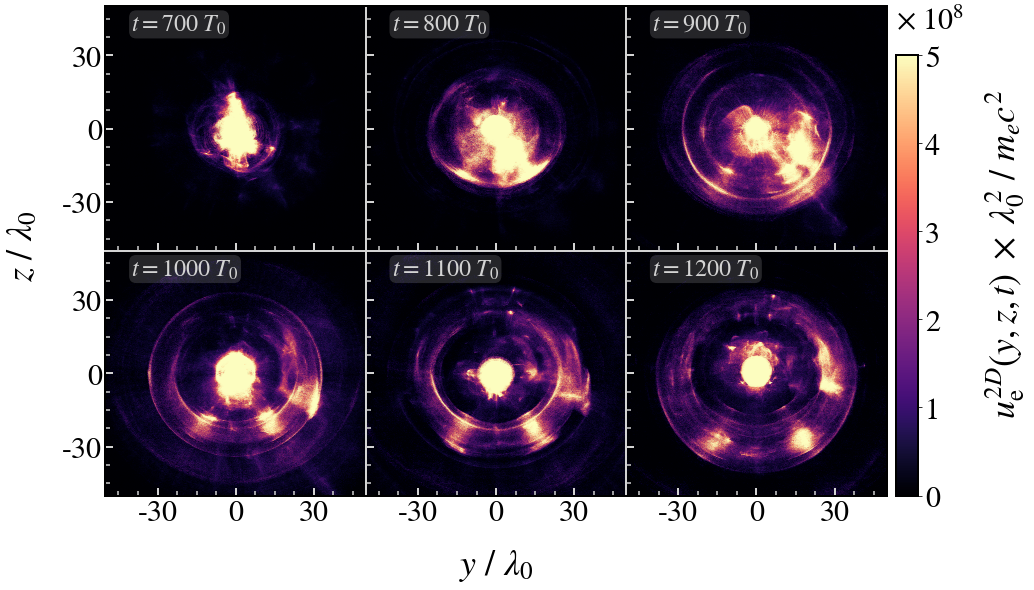

In [29]:
label_size = 36
tick_size = 30
text_size = 24

fig, ax = plt.subplots(2, 3, figsize=(14, 9))

im_1 = ax[0, 0].pcolormesh(y / lambda_0, z / lambda_0, u_e_2d_1.T, cmap="magma", shading="gouraud", vmax=0.5e9)
ax[0, 0].set_xlim(-50, 50)
ax[0, 0].set_ylim(-50, 50)
ax[0, 0].set_xticks([-30, 0, 30])
ax[0, 0].set_yticks([-30, 0, 30])
ax[0, 0].set_xticklabels([])
ax[0, 0].set_yticklabels([-30, 0, 30])
ax[0, 0].minorticks_on()
ax[0, 0].tick_params(axis="both", which="major", color="lightgray", direction="in", length=8, width=2, labelsize=tick_size)
ax[0, 0].tick_params(axis="both", which="minor", color="lightgray", direction="in", length=5, width=1.5, labelsize=tick_size)
ax[0, 0].text(-40, 40, r"$ t = 700 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
for s in ["right", "bottom"]:
    ax[0, 0].spines[s].set_color("lightgray")

im_2 = ax[0, 1].pcolormesh(y / lambda_0, z / lambda_0, u_e_2d_2.T, cmap="magma", shading="gouraud", vmax=0.5e9)
ax[0, 1].set_xlim(-50, 50)
ax[0, 1].set_ylim(-50, 50)
ax[0, 1].set_xticks([-30, 0, 30])
ax[0, 1].set_yticks([-30, 0, 30])
ax[0, 1].set_xticklabels([])
ax[0, 1].set_yticklabels([])
ax[0, 1].minorticks_on()
ax[0, 1].tick_params(axis="both", which="major", color="lightgray", direction="in", length=8, width=2, labelsize=tick_size)
ax[0, 1].tick_params(axis="both", which="minor", color="lightgray", direction="in", length=5, width=1.5, labelsize=tick_size)
ax[0, 1].text(-40, 40, r"$ t = 800 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
for s in ["left", "right", "bottom"]:
    ax[0, 1].spines[s].set_color("lightgray")

im_3 = ax[0, 2].pcolormesh(y / lambda_0, z / lambda_0, u_e_2d_3.T, cmap="magma", shading="gouraud", vmax=0.5e9)
ax[0, 2].set_xlim(-50, 50)
ax[0, 2].set_ylim(-50, 50)
ax[0, 2].set_xticks([-30, 0, 30])
ax[0, 2].set_yticks([-30, 0, 30])
ax[0, 2].set_xticklabels([])
ax[0, 2].set_yticklabels([])
ax[0, 2].minorticks_on()
ax[0, 2].tick_params(axis="both", which="major", color="lightgray", direction="in", length=8, width=2, labelsize=tick_size)
ax[0, 2].tick_params(axis="both", which="minor", color="lightgray", direction="in", length=5, width=1.5, labelsize=tick_size)
ax[0, 2].text(-40, 40, r"$ t = 900 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
for s in ["left", "bottom"]:
    ax[0, 2].spines[s].set_color("lightgray")

im_4 = ax[1, 0].pcolormesh(y / lambda_0, z / lambda_0, u_e_2d_4.T, cmap="magma", shading="gouraud", vmax=0.5e9)
ax[1, 0].set_xlim(-50, 50)
ax[1, 0].set_ylim(-50, 50)
ax[1, 0].set_xticks([-30, 0, 30])
ax[1, 0].set_yticks([-30, 0, 30])
ax[1, 0].set_xticklabels([-30, 0, 30])
ax[1, 0].set_yticklabels([-30, 0, 30])
ax[1, 0].minorticks_on()
ax[1, 0].tick_params(axis="both", which="major", color="lightgray", direction="in", length=8, width=2, labelsize=tick_size)
ax[1, 0].tick_params(axis="both", which="minor", color="lightgray", direction="in", length=5, width=1.5, labelsize=tick_size)
ax[1, 0].text(-40, 40, r"$ t = 1000 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
ax[1, 0].set_ylabel(r"$ z \ / \ \lambda_0 $", fontsize=label_size, labelpad=20)
ax[1, 0].yaxis.set_label_coords(-0.25, 1.025)
for s in ["right", "top"]:
    ax[1, 0].spines[s].set_color("lightgray")

im_5 = ax[1, 1].pcolormesh(y / lambda_0, z / lambda_0, u_e_2d_5.T, cmap="magma", shading="gouraud", vmax=0.5e9)
ax[1, 1].set_xlim(-50, 50)
ax[1, 1].set_ylim(-50, 50)
ax[1, 1].set_xticks([-30, 0, 30])
ax[1, 1].set_yticks([-30, 0, 30])
ax[1, 1].set_xticklabels([-30, 0, 30])
ax[1, 1].set_yticklabels([])
ax[1, 1].minorticks_on()
ax[1, 1].tick_params(axis="both", which="major", color="lightgray", direction="in", length=8, width=2, labelsize=tick_size)
ax[1, 1].tick_params(axis="both", which="minor", color="lightgray", direction="in", length=5, width=1.5, labelsize=tick_size)
ax[1, 1].text(-40, 40, r"$ t = 1100 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
ax[1, 1].set_xlabel(r"$ y \ / \ \lambda_0 $", fontsize=label_size, labelpad=20)
for s in ["left", "right", "top"]:
    ax[1, 1].spines[s].set_color("lightgray")

im_6 = ax[1, 2].pcolormesh(y / lambda_0, z / lambda_0, u_e_2d_6.T, cmap="magma", shading="gouraud", vmax=0.5e9)
ax[1, 2].set_xlim(-50, 50)
ax[1, 2].set_ylim(-50, 50)
ax[1, 2].set_xticks([-30, 0, 30])
ax[1, 2].set_yticks([-30, 0, 30])
ax[1, 2].set_xticklabels([-30, 0, 30])
ax[1, 2].set_yticklabels([])
ax[1, 2].minorticks_on()
ax[1, 2].tick_params(axis="both", which="major", color="lightgray", direction="in", length=8, width=2, labelsize=tick_size)
ax[1, 2].tick_params(axis="both", which="minor", color="lightgray", direction="in", length=5, width=1.5, labelsize=tick_size)
ax[1, 2].text(-40, 40, r"$ t = 1200 \ T_0 $", color="lightgray", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.15, boxstyle="round, pad=0.1, rounding_size=0.3"))
for s in ["left", "top"]:
    ax[1, 2].spines[s].set_color("lightgray")

cbar = plt.colorbar(im_3, ax=ax[:, 2], aspect=20, anchor=(3.5, 0.0), shrink=0.9)
cbar.set_label(label=r"$ u_{\mathrm{e}}^{2D} (y, z, t) \ \times \ \lambda_0^2 \ / \ m_e c^2 $", fontsize=label_size, labelpad=20)
cbar.ax.tick_params(labelsize=tick_size)
cbar.locator = mpl.ticker.MaxNLocator(nbins=6)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set_visible(False)
cbar.ax.text(0.0, 5.3e8, r'$ \times \ 10^{8} $', fontsize=tick_size)
cbar.update_ticks()
cbar.ax.yaxis.set_label_coords(4.0, 0.55)

fig.subplots_adjust(wspace=0.0)
fig.subplots_adjust(hspace=0.0)

### Fig. 8

In [30]:
file = sdf.read("./data/main/res_low_0119.sdf")
time_1 = file.Header["time"] / T_0
grid_x_1 = file.Grid_Reduced_sub_res_low_mid.data[0] / lambda_0
grid_y_1 = file.Grid_Reduced_sub_res_low_mid.data[1] / lambda_0
ne_1 = file.Derived_Number_Density_subset_sub_res_low_electron_Reduced_sub_res_low.data / n_c
ex_1 = file.Electric_Field_Ex_Reduced_sub_res_low.data / E_p
u_e_3d_1 = np.load("./data/main/u_e_3d_0011.npy")

file = sdf.read("./data/main/res_low_0139.sdf")
time_2 = file.Header["time"] / T_0
grid_x_2 = file.Grid_Reduced_sub_res_low_mid.data[0] / lambda_0
grid_y_2 = file.Grid_Reduced_sub_res_low_mid.data[1] / lambda_0
ne_2 = file.Derived_Number_Density_subset_sub_res_low_electron_Reduced_sub_res_low.data / n_c
ex_2 = file.Electric_Field_Ex_Reduced_sub_res_low.data / E_p
u_e_3d_2 = np.load("./data/main/u_e_3d_0013.npy")

file = sdf.read("./data/main/res_low_0159.sdf")
time_3 = file.Header["time"] / T_0
grid_x_3 = file.Grid_Reduced_sub_res_low_mid.data[0] / lambda_0
grid_y_3 = file.Grid_Reduced_sub_res_low_mid.data[1] / lambda_0
ne_3 = file.Derived_Number_Density_subset_sub_res_low_electron_Reduced_sub_res_low.data / n_c
ex_3 = file.Electric_Field_Ex_Reduced_sub_res_low.data / E_p
u_e_3d_3 = np.load("./data/main/u_e_3d_0015.npy")

In [31]:
angle = 130

theta_1 = angle * (2.0 * pi / 360.0)
theta_2 = (angle + 180) * (2.0 * pi / 360.0)

y_0_ek = 128
z_0_ek = 128
r_res_ek = int(np.hypot(128, 128))
r_ek = np.linspace(0, 60, r_res_ek)
y_1_ek = y_0_ek - 1 + y_0_ek * np.cos(theta_1)
z_1_ek = z_0_ek - 1 + z_0_ek * np.sin(theta_1)
y_2_ek = y_0_ek - 1 + y_0_ek * np.cos(theta_2)
z_2_ek = z_0_ek - 1 + z_0_ek * np.sin(theta_2)

y_0_f = 120
z_0_f = 120
r_res_f = int(np.hypot(120, 120))
r_f = np.linspace(0, 60, r_res_f)
y_1_f = y_0_f - 1 + y_0_f * np.cos(theta_1)
z_1_f = z_0_f - 1 + z_0_f * np.sin(theta_1)
y_2_f = y_0_f - 1 + y_0_f * np.cos(theta_2)
z_2_f = z_0_f - 1 + z_0_f * np.sin(theta_2)

x_ek_1 = np.linspace(np.min(grid_x_1) - 1, np.max(grid_x_1) + 1, 256)
x_ek_2 = np.linspace(np.min(grid_x_2) - 1, np.max(grid_x_2) + 1, 256)
x_ek_3 = np.linspace(np.min(grid_x_3) - 1, np.max(grid_x_3) + 1, 256)

up_y_ek = np.linspace(y_0_ek, y_1_ek, r_res_ek).astype(int)
up_z_ek = np.linspace(z_0_ek, z_1_ek, r_res_ek).astype(int)
down_y_ek = np.linspace(y_0_ek, y_2_ek, r_res_ek).astype(int)
down_z_ek = np.linspace(z_0_ek, z_2_ek, r_res_ek).astype(int)

up_y_f = np.linspace(y_0_f, y_1_f, r_res_f).astype(int)
up_z_f = np.linspace(z_0_f, z_1_f, r_res_f).astype(int)
down_y_f = np.linspace(y_0_f, y_2_f, r_res_f).astype(int)
down_z_f = np.linspace(z_0_f, z_2_f, r_res_f).astype(int)

ek_1_up = u_e_3d_1[:, up_y_ek, up_z_ek].T
n_1_up = ne_1[:, up_y_f, up_z_f].T
ex_1_up = ex_1[:, up_y_f, up_z_f].T
ek_1_down = u_e_3d_1[:, down_y_ek, down_z_ek].T
n_1_down = ne_1[:, down_y_f, down_z_f].T
ex_1_down = ex_1[:, down_y_f, down_z_f].T

ek_2_up = u_e_3d_2[:, up_y_ek, up_z_ek].T
n_2_up = ne_2[:, up_y_f, up_z_f].T
ex_2_up = ex_2[:, up_y_f, up_z_f].T
ek_2_down = u_e_3d_2[:, down_y_ek, down_z_ek].T
n_2_down = ne_2[:, down_y_f, down_z_f].T
ex_2_down = ex_2[:, down_y_f, down_z_f].T

ek_3_up = u_e_3d_3[:, up_y_ek, up_z_ek].T
n_3_up = ne_3[:, up_y_f, up_z_f].T
ex_3_up = ex_3[:, up_y_f, up_z_f].T
ek_3_down = u_e_3d_3[:, down_y_ek, down_z_ek].T
n_3_down = ne_3[:, down_y_f, down_z_f].T
ex_3_down = ex_3[:, down_y_f, down_z_f].T

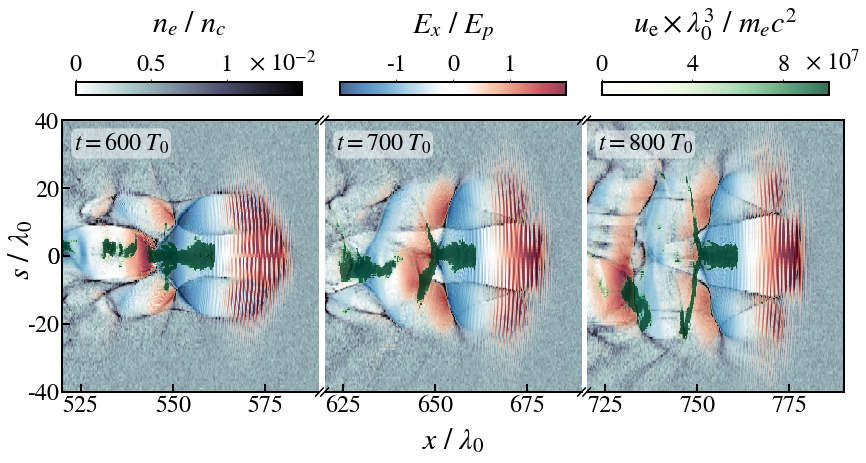

In [32]:
d = 3.0e-2
label_size = 30
tick_size = 24
text_size = 24

fig, ax = plt.subplots(2, 3, figsize=(14, 5))

ax[0, 0].pcolormesh(grid_x_1, r_f, n_1_up, shading="gouraud", cmap="bone_r", vmax=0.015)
ax[0, 0].pcolormesh(grid_x_1, r_f, ex_1_up, shading="auto", cmap=RdBu_t, vmin=-2.0, vmax=2.0)
ax[0, 0].pcolormesh(x_ek_1, r_ek, ek_1_up, cmap=Greens_t, shading="auto", vmax=1.0e8)
ax[0, 0].set_xlim(np.min(grid_x_1) + 10, np.max(grid_x_1))
ax[0, 0].set_ylim(0, 40)
ax[0, 0].set_xticks([])
ax[0, 0].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[0, 0].spines["bottom"].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].plot((1-d/2,1+d/2),(1-d,1+d), transform=ax[0, 0].transAxes, color='k', clip_on=False)
ax[0, 0].text(np.min(grid_x_1) - 5, -5, r"$ s \ / \ \lambda_0 $", fontsize=label_size, rotation=90)
ax[0, 0].text(np.min(grid_x_1) + 13, 31, r"$ t = {:d} \ T_0 $".format(int(time_1)), color="black", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.5, boxstyle="round, pad=0.1, rounding_size=0.3"))

ax[1, 0].pcolormesh(grid_x_1, r_f, n_1_down, shading="gouraud", cmap="bone_r", vmax=0.015)
ax[1, 0].pcolormesh(grid_x_1, r_f, ex_1_down, shading="auto", cmap=RdBu_t, vmin=-2.0, vmax=2.0)
ax[1, 0].pcolormesh(x_ek_1, r_ek, ek_1_down, cmap=Greens_t, shading="auto", vmax=1.0e8)
ax[1, 0].invert_yaxis()
ax[1, 0].set_xlim(np.min(grid_x_1) + 10, np.max(grid_x_1))
ax[1, 0].set_ylim(40, 0)
ax[1, 0].set_yticks([0, 20,  40])
ax[1, 0].set_yticklabels(["0", "-20", "-40"])
ax[1, 0].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[1, 0].spines["top"].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].plot((1-d/2,1+d/2), (-d,+d), transform=ax[1, 0].transAxes, color='k', clip_on=False)

ax[0, 1].pcolormesh(grid_x_2, r_f, n_2_up, shading="gouraud", cmap="bone_r", vmax=0.015)
ax[0, 1].pcolormesh(grid_x_2, r_f, ex_2_up, shading="auto", cmap=RdBu_t, vmin=-2, vmax=2)
ax[0, 1].pcolormesh(x_ek_2, r_ek, ek_2_up, cmap=Greens_t, shading="auto", vmax=1.0e8)
ax[0, 1].set_xlim(np.min(grid_x_2) + 10, np.max(grid_x_2))
ax[0, 1].set_ylim(0, 40)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 1].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[0, 1].spines["bottom"].set_visible(False)
ax[0, 1].spines['left'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].plot((-d/2,+d/2), (1-d,1+d), transform=ax[0, 1].transAxes, color='k', clip_on=False)
ax[0, 1].plot((1-d/2,1+d/2),(1-d,1+d), transform=ax[0, 1].transAxes, color='k', clip_on=False)
ax[0, 1].text(np.min(grid_x_2) + 13, 31, r"$ t = {:d} \ T_0 $".format(int(time_2)), color="black", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.5, boxstyle="round, pad=0.1, rounding_size=0.3"))

ax[1, 1].pcolormesh(grid_x_2, r_f, n_2_down, shading="gouraud", cmap="bone_r", vmax=0.015)
ax[1, 1].pcolormesh(grid_x_2, r_f, ex_2_down, shading="auto", cmap=RdBu_t, vmin=-2, vmax=2)
ax[1, 1].pcolormesh(x_ek_2, r_ek, ek_2_down, cmap=Greens_t, shading="auto", vmax=1.0e8)
ax[1, 1].invert_yaxis()
ax[1, 1].set_xlim(np.min(grid_x_2) + 10, np.max(grid_x_2))
ax[1, 1].set_ylim(40, 0)
ax[1, 1].set_yticks([])
ax[1, 1].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[1, 1].spines["top"].set_visible(False)
ax[1, 1].spines['left'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)
ax[1, 1].plot((-d/2,+d/2), (-d,+d), transform=ax[1, 1].transAxes, color='k', clip_on=False)
ax[1, 1].plot((1-d/2,1+d/2), (-d,+d), transform=ax[1, 1].transAxes, color='k', clip_on=False)
ax[1, 1].set_xlabel(r"$ x \ / \ \lambda_0 $", fontsize=label_size, labelpad=10)

ax[0, 2].pcolormesh(grid_x_3, r_f, n_3_up, shading="gouraud", cmap="bone_r", vmax=0.015)
ax[0, 2].pcolormesh(grid_x_3, r_f, ex_3_up, shading="auto", cmap=RdBu_t, vmin=-2, vmax=2)
ax[0, 2].pcolormesh(x_ek_3, r_ek, ek_3_up, cmap=Greens_t, shading="auto", vmax=1.0e8)
ax[0, 2].set_xlim(np.min(grid_x_3) + 10, np.max(grid_x_3))
ax[0, 2].set_ylim(0, 40)
ax[0, 2].set_yticks([])
ax[0, 2].set_xticks([])
ax[0, 2].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[0, 2].spines["bottom"].set_visible(False)
ax[0, 2].spines['left'].set_visible(False)
ax[0, 2].plot((-d/2,+d/2), (1-d,1+d), transform=ax[0, 2].transAxes, color='k', clip_on=False)
ax[0, 2].text(np.min(grid_x_3) + 13, 31, r"$ t = {:d} \ T_0 $".format(int(time_3)), color="black", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.5, boxstyle="round, pad=0.1, rounding_size=0.3"))

im_n = ax[1, 2].pcolormesh(grid_x_3, r_f, n_3_down, shading="gouraud", cmap="bone_r", vmax=0.015)
im_ex = ax[1, 2].pcolormesh(grid_x_3, r_f, ex_3_down, shading="auto", cmap=RdBu_t, vmin=-2, vmax=2)
im_ek = ax[1, 2].pcolormesh(x_ek_3, r_ek, ek_3_down, cmap=Greens_t, shading="auto", vmax=1.0e8)
ax[1, 2].invert_yaxis()
ax[1, 2].set_xlim(np.min(grid_x_3) + 10, np.max(grid_x_3))
ax[1, 2].set_ylim(40, 0)
ax[1, 2].set_yticks([])
ax[1, 2].tick_params(axis="both", which="major", direction="in", length=8, width=2, labelsize=tick_size)
ax[1, 2].spines["top"].set_visible(False)
ax[1, 2].spines['left'].set_visible(False)
ax[1, 2].plot((-d/2,+d/2), (-d,+d), transform=ax[1, 2].transAxes, color='k', clip_on=False)

cbax_n = fig.add_axes([0.138, 0.95, 0.225, 0.035]) 
cbar_n = plt.colorbar(im_n, cax=cbax_n, orientation="horizontal")
cbar_n.set_label(label=r"$ n_e \ / \ n_c $", fontsize=label_size, labelpad=-85)
cbar_n.ax.tick_params(labelsize=tick_size)
cbar_n.locator = mpl.ticker.MaxNLocator(nbins=4)
cbar_n.formatter.set_powerlimits((0, 0))
cbar_n.set_ticks([0, 0.5e-2, 1.0e-2])
cbar_n.set_ticklabels(["0", "0.5", "1"])
cbar_n.ax.xaxis.set_ticks_position("top")
cbar_n.ax.xaxis.offsetText.set_visible(False)
cbar_n.ax.text(0.0115, 0.029, r'$ \times \ 10^{-2} $', fontsize=tick_size)

cbax_ex = fig.add_axes([0.4, 0.95, 0.225, 0.035])
cbar_ex = plt.colorbar(im_ex, cax=cbax_ex, orientation="horizontal")
cbar_ex.set_label(label=r"$ E_x \ / \ E_p $", fontsize=label_size, labelpad=-85)
cbar_ex.ax.tick_params(labelsize=tick_size)
cbar_ex.locator = mpl.ticker.MaxNLocator(nbins=4)
cbar_ex.formatter.set_powerlimits((0, 0))
cbar_ex.set_ticks([-1, 0, 1])
cbar_ex.set_ticklabels(["-1", "0", "1"])
cbar_ex.ax.xaxis.set_ticks_position("top")
cbar_ex.ax.xaxis.offsetText.set_visible(False)

cbax_ek = fig.add_axes([0.66, 0.95, 0.225, 0.035])
cbar_ek = plt.colorbar(im_ek, cax=cbax_ek, orientation="horizontal")
cbar_ek.set_label(label=r"$ u_{\mathrm{e}} \times \lambda_0^3 \ / \ m_e c^2 $", fontsize=label_size, labelpad=-88)
cbar_ek.ax.tick_params(labelsize=tick_size)
cbar_ek.locator = mpl.ticker.MaxNLocator(nbins=4)
cbar_ek.formatter.set_powerlimits((0, 0))
cbar_ek.set_ticks([0, 4e7, 8e7])
cbar_ek.set_ticklabels(["0", "4", "8"])
cbar_ek.ax.xaxis.set_ticks_position("top")
cbar_ek.ax.xaxis.offsetText.set_visible(False)
cbar_ex.ax.text(6.2, 6.1, r'$ \times \ 10^{7} $', fontsize=tick_size)

fig.subplots_adjust(hspace=0.0)
fig.subplots_adjust(wspace=0.02)

### Fig. 9

In [33]:
file = sdf.read("./data/main/elns_frac_0239.sdf")
x = file.Grid_Particles_subset_sub_elns_frac_electron.data[0] / lambda_0
y = file.Grid_Particles_subset_sub_elns_frac_electron.data[1] / lambda_0
z = file.Grid_Particles_subset_sub_elns_frac_electron.data[2] / lambda_0
px = file.Particles_Px_subset_sub_elns_frac_electron.data / (m_e * c)
py = file.Particles_Py_subset_sub_elns_frac_electron.data / (m_e * c)
pz = file.Particles_Pz_subset_sub_elns_frac_electron.data / (m_e * c)
weight = file.Particles_Weight_subset_sub_elns_frac_electron.data

In [34]:
ek = m_e * c**2 * (np.sqrt(1.0 + px**2 + py**2 + pz**2) - 1.0) / elementary_charge / 1.0e6
axis = np.where(y**2 + z**2 <= 20.0**2)
ring = np.where(y**2 + z**2 > 20.0**2)
energies_axis, de_axis = np.linspace(0, np.max(ek[axis]), 400, retstep=True)
energies_ring, de_ring = np.linspace(0, np.max(ek[ring]), 200, retstep=True)
h_axis = np.histogram(ek[axis], weights=(weight[axis] * elementary_charge / 1.0e-12), bins=energies_axis)
h_ring = np.histogram(ek[ring], weights=(weight[ring] * elementary_charge / 1.0e-12), bins=energies_ring)
x_axis = h_axis[1][0:-1]
x_ring = h_ring[1][0:-1]
spectrum_axis = h_axis[0] / de_axis * 10.0
spectrum_ring = h_ring[0] / de_ring * 10.0
spectrum_ring[spectrum_ring > 60.0] = 60.0
spectrum_axis[spectrum_axis > 60.0] = 60.0
verts = []
verts.append(list(zip(x_ring, spectrum_ring)))
verts.append(list(zip(x_axis[:-50], spectrum_axis[:-50])))

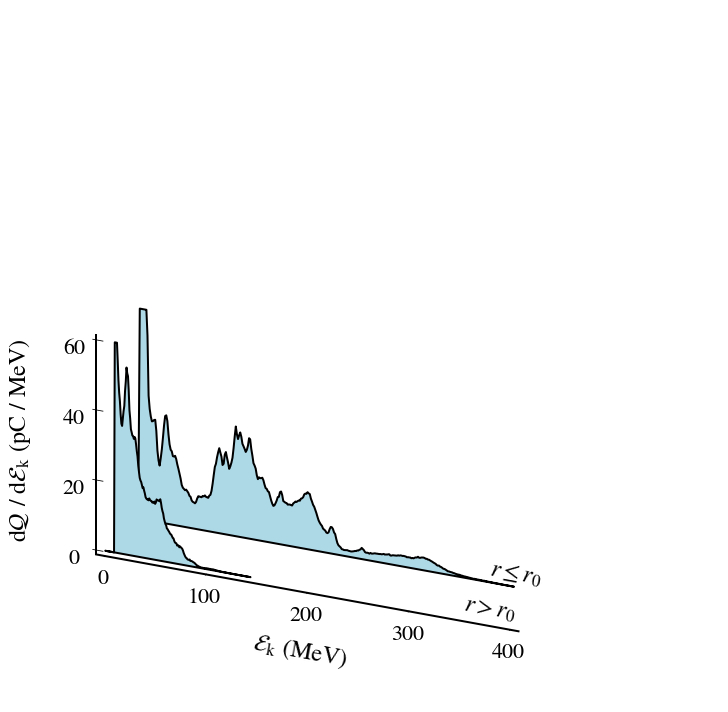

In [35]:
fig, ax = plt.subplots(figsize=(10, 12), subplot_kw={"projection": "3d", "proj_type": "ortho"})

poly = mpl.collections.PolyCollection(verts, alpha=1.0, edgecolor="black", facecolor="lightblue", linewidths=2)
ax.add_collection3d(poly, zs=np.linspace(0, 0.25, 2), zdir="y")
ax.view_init(30.0, -70.0)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.0, 0.2, 0.75, 1]))
ax.set_xlim(10.0, 400.0)
ax.set_ylim(0.0, 0.3)
ax.set_zlim(0.0, 60.0)
ax.set_xticks([0, 100, 200, 300, 400])
ax.set_yticks([])
ax.set_zticks([0, 20, 40, 60])
ax.set_xlabel(r"$ \mathrm{\mathcal{E}_k \ (MeV)} $", fontsize=24, labelpad=60)
ax.set_zlabel(r"$ \mathrm{d\mathcal{Q} \ / \ d\mathcal{E}_k \ (pC \ / \ MeV)} $", fontsize=24, labelpad=40)
ax.tick_params(axis="x", labelsize=22, pad=10)
ax.tick_params(axis="z", labelsize=22, pad=10)
ax.text(350, 0.02, -2, r"$ r > r_0 $", color="black", fontsize=24, zdir="x")
ax.text(350, 0.28, -2, r"$ r \leq r_0 $", color="black", fontsize=24, zdir="x")
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor("white")
ax.yaxis.pane.set_edgecolor("white")
ax.zaxis.pane.set_edgecolor("white")
ax.yaxis._axinfo['juggled'] = (1, 1, 1)
ax.zaxis._axinfo['juggled'] = (-2, 2, 0)
fig.tight_layout()

### Fig. 10

In [36]:
a_0_s = [4, 6, 8, 10, 12, 14, 16, 18, 20]
E_init = []
u_em_1d = []
verts = []
r = np.linspace(0.0 * lambda_0, 75.0 * lambda_0, int(np.hypot(375, 375)))
for a_0 in a_0_s[::-1]:
    E_init.append((a_0 / (8.5493e-6 * lambda_0))**2 * w_0**2 * tau_0 / (2.0 * np.sqrt(np.log(2.0))) * (pi / 2.0)**(1.5))
    u_em_1d.append(np.load("./data/param_study/05_{:d}_6/u_em_1d_0099.npy".format(a_0)))
    verts.append(list(zip(r / lambda_0, u_em_1d[-1] * lambda_0 / E_init[-1])))

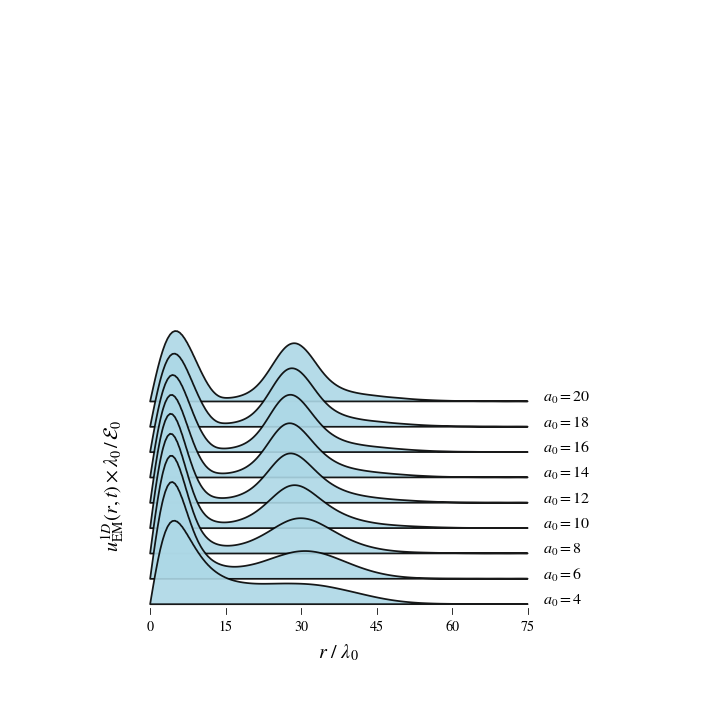

In [37]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d", "proj_type": "ortho"}, figsize=(10, 10))
poly = mpl.collections.PolyCollection(verts, alpha=0.9, edgecolor="black", facecolor="lightblue", linewidths=1.75)
ax.add_collection3d(poly, zs=np.linspace(1.5, 0, 9), zdir="y")
ax.view_init(70.0, -90.0)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.75, 1.0, 1.5, 2.0]))
ax.set_xlim(0.0, 75.0)
ax.set_ylim(0.0, 1.5)
ax.set_zlim(0.0, 0.06)
ax.set_xticks([0, 15, 30, 45, 60, 75])
ax.set_yticks([])
ax.set_zticks([])
ax.text(-10, 0.45, 0.0, r"$ u_{\mathrm{EM}}^{1D} (r, t) \times \lambda_0 \, / \, \mathcal{E}_0 $", "z", fontsize=20)
ax.set_xlabel(r"$ r \ / \ \lambda_0 $", fontsize=20, labelpad=30)
ax.tick_params(axis="x", labelsize=14, width=10)
ax.text(78, 8 * 0.1875, 0, r"$ a_0 = 20 $", color="black", fontsize=16)
ax.text(78, 7 * 0.1875, 0, r"$ a_0 = 18 $", color="black", fontsize=16)
ax.text(78, 6 * 0.1875, 0, r"$ a_0 = 16 $", color="black", fontsize=16)
ax.text(78, 5 * 0.1875, 0, r"$ a_0 = 14 $", color="black", fontsize=16)
ax.text(78, 4 * 0.1875, 0, r"$ a_0 = 12 $", color="black", fontsize=16)
ax.text(78, 3 * 0.1875, 0, r"$ a_0 = 10 $", color="black", fontsize=16)
ax.text(78, 2 * 0.1875, 0, r"$ a_0 = 8 $", color="black", fontsize=16)
ax.text(78, 1 * 0.1875, 0, r"$ a_0 = 6 $", color="black", fontsize=16)
ax.text(78, 0 * 0.1875, 0, r"$ a_0 = 4 $", color="black", fontsize=16)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor("white")
ax.yaxis.pane.set_edgecolor("white")
ax.zaxis.pane.set_edgecolor("white")
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
fig.tight_layout()

### Fig. 11

In [38]:
a_0_s = [6, 8, 10, 12, 14, 16, 18, 20]
r, d_r = np.linspace(0.0 * lambda_0, 75.0 * lambda_0, int(np.hypot(375, 375)), retstep=True)
energies = []
opening_angles = []
for a_0 in a_0_s:
    ring_energy_time = np.zeros(150)
    r_1_time = np.zeros(150)
    E_init = (a_0 / (8.5493e-6 * lambda_0))**2 * w_0**2 * tau_0 / (2.0 * np.sqrt(np.log(2.0))) * (pi / 2.0)**(1.5)
    for t in range(80, 150):
        u_em_1d = np.load("./data/param_study/" + "05_{:d}_6".format(a_0) + "/u_em_1d_{:04d}.npy".format(t))
        r_0 = find_peaks(-u_em_1d, width=5)[0][0]
        r_1 = find_peaks(u_em_1d, width=5)[0][1]
        ring_energy_time[t] = np.sum(u_em_1d[r_0:]) * d_r
        r_1_time[t] = r[r_1]
    energies.append(np.average(ring_energy_time[80:120]) / E_init * 100.0)
    opening_angles.append(np.average(2.0 * np.arcsin(np.gradient(r_1_time[80:120] / (10.0 * lambda_0) / np.sqrt(1.0 - n_0 / n_c)))) * 1000.0)

In [39]:
def func_powerlaw(x, a, b, c):
    return a * x**b + c

popt1, pcov1 = curve_fit(func_powerlaw, a_0_s, energies, p0=[-136.4, -0.9675, 65.17])
popt2, pcov2 = curve_fit(func_powerlaw, a_0_s, opening_angles, p0=[225.6, -0.2877, -34.14])

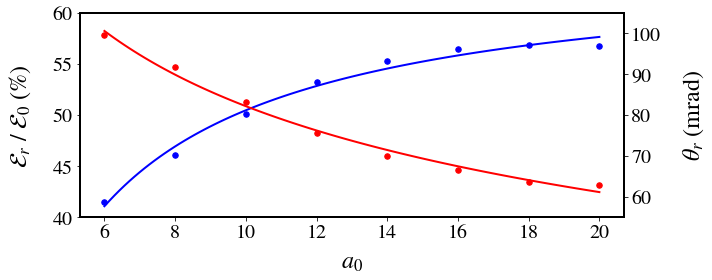

In [40]:
x = np.linspace(6.0, 20.0, 100)

fig, ax_1 = plt.subplots(figsize=(10, 4))
ax_2 = ax_1.twinx()
ax_1.scatter(a_0_s, energies, s=30, marker="o", color="blue")
ax_1.plot(x, func_powerlaw(x, *popt1), color="blue", linewidth=2.0)
ax_1.tick_params(axis="both", which="major", labelsize=20)
ax_1.set_xlabel(r"$ a_0 $", fontsize=24, labelpad=10)
ax_1.set_ylabel(r"$ \mathcal{E}_r \ / \ \mathcal{E}_0 \ (\%) $", fontsize=24, labelpad=20)
ax_1.set_ylim(40, 60)
ax_2.scatter(a_0_s, opening_angles, s=30, marker="o", color="red")
ax_2.plot(x, func_powerlaw(x, *popt2), color="red", linewidth=2.0)
ax_2.tick_params(axis="both", which="major", labelsize=20)
ax_2.set_ylabel(r"$ \theta_r \ (\mathrm{mrad}) $", fontsize=24, labelpad=20)
ax_2.set_ylim(55, 105)
fig.tight_layout()

### Fig. 12

In [41]:
a_0_1 = 8.0
E_0_1 = m_e * c * omega_0 * a_0_1 / elementary_charge
a_0_2 = 18.0
E_0_2 = m_e * c * omega_0 * a_0_2 / elementary_charge

field = sdf.read("./data/param_study/05_8_6/field0079.sdf")
dens = sdf.read("./data/param_study/05_8_6/dens0079.sdf")
grid_x_1 = field.Grid_Grid.data[0] / lambda_0
grid_y_1 = field.Grid_Grid.data[1] / lambda_0
ne_xy_1 = dens.Derived_Number_Density_electron.data[:, :, 375] / n_c
ez_xy_1 = field.Electric_Field_Ez.data[:, :, 375] / E_0_1

field = sdf.read("./data/param_study/05_18_6/field0079.sdf")
dens = sdf.read("./data/param_study/05_18_6/dens0079.sdf")
grid_x_2 = field.Grid_Grid.data[0] / lambda_0
grid_y_2 = field.Grid_Grid.data[1] / lambda_0
ne_xy_2 = dens.Derived_Number_Density_electron.data[:, :, 375] / n_c
ez_xy_2 = field.Electric_Field_Ez.data[:, :, 375] / E_0_2

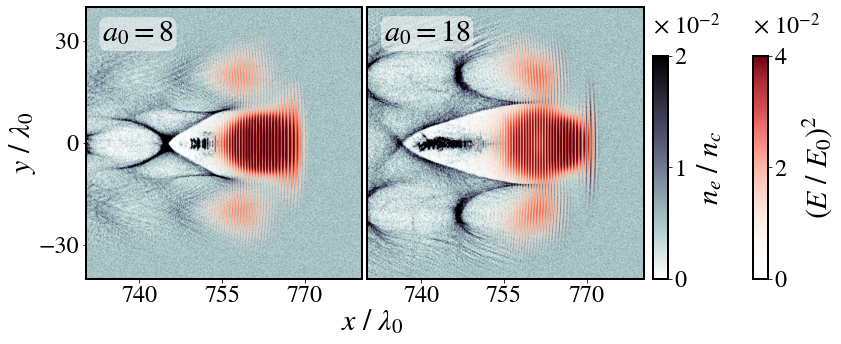

In [42]:
label_size = 30
tick_size = 24
text_size = 30

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

im_ne_xy_1 = ax[0].pcolormesh(grid_x_1[0:-1], grid_y_1[0:-1], ne_xy_1.T, cmap="bone_r", shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.02))
im_ez_xy_1 = ax[0].pcolormesh(grid_x_1[0:-1], grid_y_1[0:-1], ez_xy_1.T**2, cmap=Reds_t, shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.04))
ax[0].set_xlim(grid_x_1.max() - 50, grid_x_1.max())
ax[0].set_ylim(grid_y_1.min() + 35, grid_y_1.max() - 35)
ax[0].set_xticks([740, 755, 770])
ax[0].set_yticks([-30, 0, 30])
ax[0].tick_params(axis="both", which="major", labelsize=tick_size)
ax[0].set_ylabel(r"$ y \ / \ \lambda_0 $", fontsize=label_size, labelpad=0)
ax[0].text(grid_x_1.max() - 47, 30, r"$ a_0 = 8 $", color="black", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.5, boxstyle="round, pad=0.1, rounding_size=0.3"))

im_ne_xy_2 = ax[1].pcolormesh(grid_x_2[0:-1], grid_y_2[0:-1], ne_xy_2.T, cmap="bone_r", shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.02))
im_ez_xy_2 = ax[1].pcolormesh(grid_x_2[0:-1], grid_y_2[0:-1], ez_xy_2.T**2, cmap=Reds_t, shading="gouraud", norm=mpl.colors.Normalize(0.0, 0.04))
ax[1].set_xlim(grid_x_2.max() - 50, grid_x_2.max())
ax[1].set_ylim(grid_y_2.min() + 35, grid_y_2.max() - 35)
ax[1].set_xticks([740, 755, 770])
ax[1].set_yticks([])
ax[1].tick_params(axis="both", which="major", labelsize=tick_size)
ax[1].text(grid_x_1.max() - 47, 30, r"$ a_0 = 18 $", color="black", fontsize=text_size, bbox=dict(facecolor="white", edgecolor="none", alpha=0.5, boxstyle="round, pad=0.1, rounding_size=0.3"))
ax[0].text(776.5, -55, r"$ x \ / \ \lambda_0 $", fontsize=label_size)

cbar_1 = plt.colorbar(im_ez_xy_1, ax=ax[:], aspect=15, ticks=[0.0e-2, 2.0e-2, 4.0e-2], anchor=(2.8, 0.0), shrink=0.82)
cbar_1.set_label(label=r"$ \left( E \ / \ E_0 \right)^{2} $", fontsize=label_size, labelpad=15)
cbar_1.ax.tick_params(labelsize=tick_size)
cbar_1.formatter.set_powerlimits((0, 0))
cbar_1.ax.yaxis.offsetText.set_visible(False)
cbar_1.ax.text(0.0, 0.044, r'$ \times \ 10^{-2} $', fontsize=tick_size)
cbar_1.update_ticks()

cbar_2 = plt.colorbar(im_ne_xy_1, ax=ax[:], aspect=15, ticks=[0.0e-2, 1.0e-2, 2.0e-2], anchor=(3.6, 0.0), shrink=0.82)
cbar_2.set_label(label=r"$ n_e \ / \ n_c $", fontsize=label_size, labelpad=10)
cbar_2.ax.tick_params(labelsize=tick_size)
cbar_2.formatter.set_powerlimits((0, 0))
cbar_2.ax.yaxis.offsetText.set_visible(False)
cbar_2.ax.text(0.0, 0.022, r'$ \times \ 10^{-2} $', fontsize=tick_size)
cbar_2.update_ticks()

fig.subplots_adjust(wspace=0.02)

### Fig. 13

In [43]:
a_0_s = np.array([14, 16, 18], dtype=np.float32)
w_0_s = np.array([4, 6, 8], dtype=np.float32)
n_0_s = np.array([0.4, 0.5, 0.6], dtype=np.float32)
r, d_r = np.linspace(0.0 * lambda_0, 75.0 * lambda_0, int(np.hypot(375, 375)), retstep=True)
energies = []
opening_angles = []
for n_0 in n_0_s:
    for a_0 in a_0_s:
        for w_0 in w_0_s:
            n_0_aux = str(n_0).split('.')
            key = ''.join(n_0_aux) + "_{:d}_{:d}".format(int(a_0), int(w_0))
            ring_energy_time = np.zeros(130)
            r_1_time = np.zeros(150)
            E_init = (a_0 / (8.5493e-6 * lambda_0))**2 * (w_0 * lambda_0)**2 * tau_0 / (2.0 * np.sqrt(np.log(2.0))) * (pi / 2.0)**(1.5)
            for t in range(80, 130):
                u_em_1d = np.load("./data/param_study/" + key + "/u_em_1d_{:04d}.npy".format(t))
                r_0 = find_peaks(-u_em_1d, width=5)[0][0]
                r_1 = find_peaks(u_em_1d, width=5)[0][1]
                ring_energy_time[t] = np.sum(u_em_1d[r_0:]) * d_r
                r_1_time[t] = r[r_1]
            energies.append(np.average(ring_energy_time[80:120]) / E_init * 100.0)
            opening_angles.append(np.average(2.0 * np.arcsin(np.gradient(r_1_time[80:120] / (10.0 * lambda_0) / np.sqrt(1.0 - n_0 * 0.01)))) * 1000.0)      

In [44]:
N = 100
inp = np.array(np.meshgrid(a_0_s, w_0_s, n_0_s), dtype=np.float32).T.reshape(-1, 3)
x_new, y_new, z_new = np.meshgrid(np.linspace(np.min(a_0_s), np.max(a_0_s), N, dtype=np.float32), \
                                  np.linspace(np.min(w_0_s), np.max(w_0_s), N, dtype=np.float32), \
                                  np.linspace(np.min(n_0_s), np.max(n_0_s), N, dtype=np.float32), indexing="ij")
opening_angles_interp = Rbf(inp[:, 0], inp[:, 1], inp[:, 2], opening_angles, function="gaussian", epsilon=10)
energies_interp = Rbf(inp[:, 0], inp[:, 1], inp[:, 2], energies, function="gaussian", epsilon=10)
p_over_p_cr = 1.2351 * np.linspace(np.min(a_0_s), np.max(a_0_s), N)[:, None, None]**2 * np.linspace(np.min(w_0_s), np.max(w_0_s), N)[None, :, None]**2 * np.linspace(np.min(n_0_s), np.max(n_0_s), N)[None, None, :] * 0.01

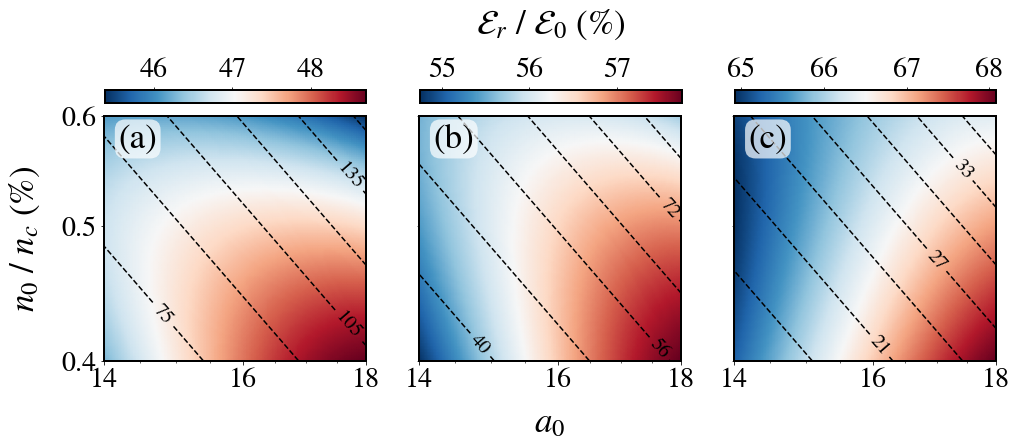

In [45]:
slice_0 = 99
slice_1 = 49
slice_2 = 0

fig, ax = plt.subplots(1, 3, figsize=(16, 4.5))

ax[0].set_xscale("log", base=10)
ax[0].set_yscale("log", base=10)
im_0 = ax[0].pcolormesh(x_new[:, slice_0, :], z_new[:, slice_0, :], \
                        energies_interp(x_new, y_new, z_new)[:, slice_0, :].astype(np.float32), cmap="RdBu_r", \
                        shading="gouraud")
co_0 = ax[0].contour(x_new[:, slice_0, :], z_new[:, slice_0, :], p_over_p_cr[:, slice_0, :], \
                     colors="black", linestyles="--", levels=7)
ax[0].clabel(co_0, [75, 105, 135], fontsize=20, inline=True, fmt="%d")
ax[0].set_xlim(14, 18)
ax[0].set_ylim(0.4, 0.6)
ax[0].tick_params(axis="both", which="major", labelsize=28)
ax[0].set_xticks([14, 16, 18])
ax[0].set_yticks([0.4, 0.5, 0.6])
ax[0].set_xticklabels(["14", "16", "18"])
ax[0].set_yticklabels(["0.4", "0.5", "0.6"])
ax[0].set_ylabel(r"$ n_0 \ / \ n_c \ (\%) $", fontsize=35, labelpad=20)
ax[0].text(14.2, 0.57, "(a)", color='black', size=35, bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round, pad=0.1, rounding_size=0.3"))
for axis in [ax[0].xaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
cax_0 = fig.add_axes([0.126, 0.92, 0.227, 0.04])
cbar = plt.colorbar(im_0, cax=cax_0, aspect=20, orientation="horizontal", ticks=[46, 47, 48])
cbar.ax.tick_params(labelsize=28)
cbar.ax.xaxis.set_ticks_position('top')

ax[1].set_xscale("log", base=10)
ax[1].set_yscale("log", base=10)
im_1 = ax[1].pcolormesh(x_new[:, slice_1, :], z_new[:, slice_1, :], \
                        energies_interp(x_new, y_new, z_new)[:, slice_1, :].astype(np.float32), cmap="RdBu_r", \
                        shading="gouraud")
co_1 = ax[1].contour(x_new[:, slice_1, :], z_new[:, slice_1, :], p_over_p_cr[:, slice_1, :], \
                     colors="black", linestyles="--", levels=7)
ax[1].clabel(co_1, [40, 56, 72], fontsize=20, inline=True, fmt="%d")
ax[1].set_xlim(14, 18)
ax[1].set_ylim(0.4, 0.6)
ax[1].tick_params(axis="both", which="major", labelsize=28)
ax[1].set_xticks([14, 16, 18])
ax[1].set_yticks([])
ax[1].set_xticklabels(["14", "16", "18"])
ax[1].set_yticklabels([])
ax[1].set_xlabel(r"$ a_0 $", fontsize=35, labelpad=15)
ax[1].text(14.2, 0.57, "(b)", color='black', size=35, bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round, pad=0.1, rounding_size=0.3"))
for axis in [ax[1].xaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
for axis in [ax[1].yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
cax_1 = fig.add_axes([0.4, 0.92, 0.227, 0.04])
cbar_1 = plt.colorbar(im_1, cax=cax_1, aspect=20, orientation="horizontal", ticks=[55, 56, 57])
cbar_1.set_label(label=r"$ \mathcal{E}_r \ / \ \mathcal{E}_0 \ (\%) $", fontsize=35, labelpad=25)
cbar_1.ax.tick_params(labelsize=28)
cbar_1.ax.xaxis.set_ticks_position('top')
cbar_1.ax.xaxis.set_label_position('top')

ax[2].set_xscale("log", base=10)
ax[2].set_yscale("log", base=10)
im_2 = ax[2].pcolormesh(x_new[:, slice_2, :], z_new[:, slice_2, :], \
                        energies_interp(x_new, y_new, z_new)[:, slice_2, :].astype(np.float32), cmap="RdBu_r", \
                        shading="gouraud")
co_2 = ax[2].contour(x_new[:, slice_2, :], z_new[:, slice_2, :], p_over_p_cr[:, slice_2, :], \
                     colors="black", linestyles="--", levels=7)
ax[2].clabel(co_2, [21, 27, 33], fontsize=20, inline=True, fmt="%d")
ax[2].set_xlim(14, 18)
ax[2].set_ylim(0.4, 0.6)
ax[2].tick_params(axis="both", which="major", labelsize=28)
ax[2].set_xticks([14, 16, 18])
ax[2].set_yticks([])
ax[2].set_xticklabels(["14", "16", "18"])
ax[2].set_yticklabels([])
ax[2].text(14.2, 0.57, "(c)", color='black', size=35, bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round, pad=0.1, rounding_size=0.3"))
for axis in [ax[2].xaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
for axis in [ax[2].yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
cax_2 = fig.add_axes([0.673, 0.92, 0.227, 0.04])
cbar_2 = plt.colorbar(im_2, cax=cax_2, aspect=20, orientation="horizontal", ticks=[65, 66, 67, 68])
cbar_2.ax.tick_params(labelsize=28)
cbar_2.ax.xaxis.set_ticks_position('top')

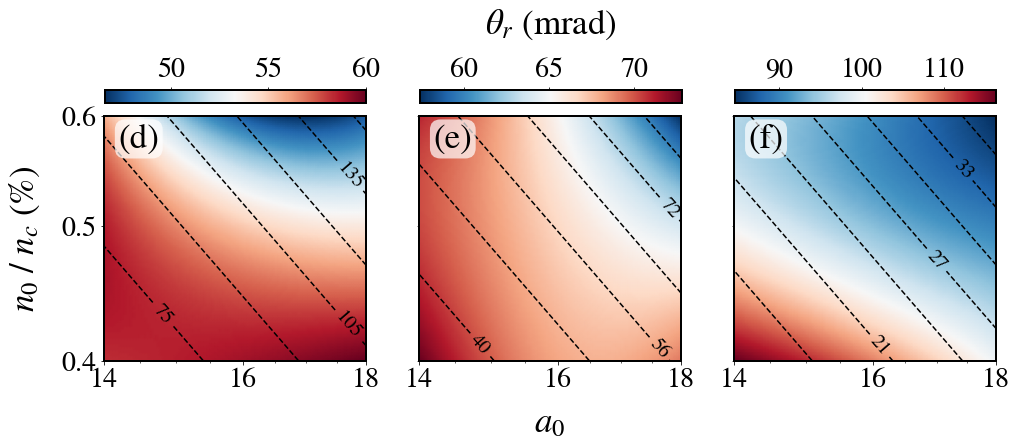

In [46]:
slice_0 = 99
slice_1 = 49
slice_2 = 0

fig, ax = plt.subplots(1, 3, figsize=(16, 4.5))

ax[0].set_xscale("log", base=10)
ax[0].set_yscale("log", base=10)
im_0 = ax[0].pcolormesh(x_new[:, slice_0, :], z_new[:, slice_0, :], \
                        opening_angles_interp(x_new, y_new, z_new)[:, slice_0, :].astype(np.float32), cmap="RdBu_r", \
                        shading="gouraud")
co_0 = ax[0].contour(x_new[:, slice_0, :], z_new[:, slice_0, :], p_over_p_cr[:, slice_0, :], \
                     colors="black", linestyles="--", levels=7)
ax[0].clabel(co_0, [75, 105, 135], fontsize=20, inline=True, fmt="%d")
ax[0].set_xlim(14, 18)
ax[0].set_ylim(0.4, 0.6)
ax[0].tick_params(axis="both", which="major", labelsize=28)
ax[0].set_xticks([14, 16, 18])
ax[0].set_yticks([0.4, 0.5, 0.6])
ax[0].set_xticklabels(["14", "16", "18"])
ax[0].set_yticklabels(["0.4", "0.5", "0.6"])
ax[0].set_ylabel(r"$ n_0 \ / \ n_c \ (\%) $", fontsize=35, labelpad=20)
ax[0].text(14.2, 0.57, "(d)", color='black', size=35, bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round, pad=0.1, rounding_size=0.3"))
for axis in [ax[0].xaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
cax_0 = fig.add_axes([0.126, 0.92, 0.227, 0.04])
cbar = plt.colorbar(im_0, cax=cax_0, aspect=20, orientation="horizontal", ticks=[50, 55, 60])
cbar.ax.tick_params(labelsize=28)
cbar.ax.xaxis.set_ticks_position('top')

ax[1].set_xscale("log", base=10)
ax[1].set_yscale("log", base=10)
im_1 = ax[1].pcolormesh(x_new[:, slice_1, :], z_new[:, slice_1, :], \
                        opening_angles_interp(x_new, y_new, z_new)[:, slice_1, :].astype(np.float32), cmap="RdBu_r", \
                        shading="gouraud")
co_1 = ax[1].contour(x_new[:, slice_1, :], z_new[:, slice_1, :], p_over_p_cr[:, slice_1, :], \
                     colors="black", linestyles="--", levels=7)
ax[1].clabel(co_1, [40, 56, 72], fontsize=20, inline=True, fmt="%d")
ax[1].set_xlim(14, 18)
ax[1].set_ylim(0.4, 0.6)
ax[1].tick_params(axis="both", which="major", labelsize=28)
ax[1].set_xticks([14, 16, 18])
ax[1].set_yticks([])
ax[1].set_xticklabels(["14", "16", "18"])
ax[1].set_yticklabels([])
ax[1].set_xlabel(r"$ a_0 $", fontsize=35, labelpad=15)
ax[1].text(14.2, 0.57, "(e)", color='black', size=35, bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round, pad=0.1, rounding_size=0.3"))
for axis in [ax[1].xaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
for axis in [ax[1].yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
cax_1 = fig.add_axes([0.4, 0.92, 0.227, 0.04])
cbar_1 = plt.colorbar(im_1, cax=cax_1, aspect=20, orientation="horizontal", ticks=[60, 65, 70])
cbar_1.set_label(label=r"$ \theta_r \ \mathrm{(mrad)} $", fontsize=35, labelpad=25)
cbar_1.ax.tick_params(labelsize=28)
cbar_1.ax.xaxis.set_ticks_position('top')
cbar_1.ax.xaxis.set_label_position('top')

ax[2].set_xscale("log", base=10)
ax[2].set_yscale("log", base=10)
im_2 = ax[2].pcolormesh(x_new[:, slice_2, :], z_new[:, slice_2, :], \
                        opening_angles_interp(x_new, y_new, z_new)[:, slice_2, :].astype(np.float32), cmap="RdBu_r", \
                        shading="gouraud")
co_2 = ax[2].contour(x_new[:, slice_2, :], z_new[:, slice_2, :], p_over_p_cr[:, slice_2, :], \
                     colors="black", linestyles="--", levels=7)
ax[2].clabel(co_2, [21, 27, 33], fontsize=20, inline=True, fmt="%d")
ax[2].set_xlim(14, 18)
ax[2].set_ylim(0.4, 0.6)
ax[2].tick_params(axis="both", which="major", labelsize=28)
ax[2].set_xticks([14, 16, 18])
ax[2].set_yticks([])
ax[2].set_xticklabels(["14", "16", "18"])
ax[2].set_yticklabels([])
ax[2].text(14.2, 0.57, "(f)", color='black', size=35, bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round, pad=0.1, rounding_size=0.3"))
for axis in [ax[2].xaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
for axis in [ax[2].yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
cax_2 = fig.add_axes([0.673, 0.92, 0.227, 0.04])
cbar_2 = plt.colorbar(im_2, cax=cax_2, aspect=20, orientation="horizontal", ticks=[90, 100, 110],)
cbar_2.ax.tick_params(labelsize=28)
cbar_2.ax.xaxis.set_ticks_position('top')